# **SOURCE**
presentation: https://gibbons-lab.github.io/isb_course_2024/16S/

In [30]:
!git clone https://github.com/gibbons-lab/isb_course_2024 materials

fatal: destination path 'materials' already exists and is not an empty directory.


# **COLLECT DATA FROM SRA NCBI**

In [6]:
import sys
import time
import contextlib
with open('install.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !pip install biopython
        #!conda install -c bioconda sra-tools -y

        end = time.time()
        # -- End installation --
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

+ Time elapsed: 00m 13s


In [7]:
import os
import csv
import subprocess
import shutil
from Bio import Entrez
import xml.etree.ElementTree as ET
import gzip
from itertools import zip_longest

#(Chronic obstructive pulmonary disease) AND "Homo sapiens"[orgn:__txid9606]
class SRAExplorerDownloader:
    def __init__(self, email, retmax=10, output_dir="sra_downloads"):
        Entrez.email = email
        self.retmax = retmax
        self.output_dir = os.path.abspath(output_dir)
        os.makedirs(self.output_dir, exist_ok=True)

    def search_sra(self, query=None, sra_ids=None, organism=None, tech=None, date=None):
        """
        Search SRA database either by query terms or with direct SRA IDs.

        Parameters:
        - query: Search terms (e.g., "metagenomic gut microbiome")
        - sra_ids: List of direct SRA accession codes (e.g., ["SRR123", "ERR456"])
        - organism: Filter by organism (e.g., "Homo sapiens")
        - tech: Filter by technology (e.g., "Illumina")
        - date: Filter by date range (e.g., "2020:2023")

        Returns:
        List of SRA IDs matching the search criteria
        """
        if sra_ids:
            # If direct SRA IDs are provided, validate and return them
            if not isinstance(sra_ids, (list, tuple)):
                raise ValueError("sra_ids should be a list or tuple of accession codes")

            print(f"[INFO] Using provided SRA IDs: {', '.join(sra_ids[:3])}" +
                ("..." if len(sra_ids) > 3 else ""))
            return list(sra_ids)[:self.retmax]  # Apply retmax limit

        elif query:
            # Build search term from query and filters
            search_term = query
            if organism:
                search_term += f" AND {organism}[Organism]"
            if tech:
                search_term += f" AND {tech}[Strategy]"
            if date:
                search_term += f" AND ({date}[Publication Date])"

            print(f"[INFO] Searching SRA for: {search_term}")
            try:
                handle = Entrez.esearch(db="sra", term=search_term, retmax=self.retmax)
                result = Entrez.read(handle)
                handle.close()
                return result["IdList"]
            except Exception as e:
                print(f"[ERROR] SRA search failed: {str(e)}")
                return []

        else:
            raise ValueError("Either query or sra_ids must be provided")

    def fetch_metadata(self, id_list):
        all_metadata = []
        for sra_id in id_list:
            print(f"[INFO] Fetching XML metadata for {sra_id}...")
            try:
                handle = Entrez.efetch(db="sra", id=sra_id, rettype="full", retmode="xml")
                xml_data = handle.read()
                handle.close()
                root = ET.fromstring(xml_data)
                all_metadata.append((sra_id, root))
            except Exception as e:
                print(f"[ERROR] Failed to fetch metadata for {sra_id}: {e}")
        return all_metadata

    def display_and_select_runs(self, parsed_xml_data):
        run_ids = []
        meta_rows = []
        print(f"\n[RESULTS] Found {len(parsed_xml_data)} datasets:\n")

        for idx, (sra_id, root) in enumerate(parsed_xml_data):
            try:
                exp_package = root.find(".//EXPERIMENT_PACKAGE")
                title = exp_package.findtext(".//STUDY_TITLE", default="No title")
                organism = exp_package.findtext(".//SCIENTIFIC_NAME", default="Unknown")
                tech = exp_package.findtext(".//INSTRUMENT_MODEL", default="Unknown")
                pub_date = exp_package.findtext(".//DATE", default="Unknown")

                runs = []
                for run in exp_package.findall(".//RUN"):
                    run_accession = run.attrib.get("accession")
                    if run_accession:
                        runs.append(run_accession)

                print(f"{idx+1}. {title}")
                print(f"   Organism: {organism} | Technology: {tech} | Date: {pub_date}")
                print(f"   Run IDs: {', '.join(runs)}\n")

                run_ids.extend(runs)
                meta_rows.append([sra_id, title, organism, tech, pub_date, ';'.join(runs)])
            except Exception as e:
                print(f"[WARNING] Failed to parse XML for {sra_id}: {e}")

        # Save metadata CSV
        meta_path = os.path.join(self.output_dir, "sra_metadata.csv")
        with open(meta_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["SRA_ID", "Title", "Organism", "Technology", "Publication_Date", "Run_IDs"])
            writer.writerows(meta_rows)

        print(f"[INFO] Metadata CSV saved to: {meta_path}")
        return run_ids

    def download_sra_fastq(self, sra_id, temp_dir=None):
        print(f"\n[DOWNLOAD] Starting download for: {sra_id}")

        # Create temporary directory if not specified
        temp_path = temp_dir if temp_dir else os.path.join(self.output_dir, "tmp")
        os.makedirs(temp_path, exist_ok=True)

        # Check disk space
        total, used, free = shutil.disk_usage(self.output_dir)
        free_gb = free / (1024**3)
        print(f"[INFO] Free disk space: {free_gb:.2f} GB")

        if free_gb < 5:
            print(f"[WARNING] Less than 5GB disk space remaining - high risk of failure")

        try:
            # Prefetch first
            subprocess.run(["prefetch", sra_id, "--output-directory", self.output_dir], check=True)

            # Convert to FASTQ
            sra_path = os.path.join(self.output_dir, sra_id, f"{sra_id}.sra")
            print(f"[INFO] Converting {sra_path} to FASTQ...")

            subprocess.run([
                "fasterq-dump", sra_path,
                "-O", self.output_dir,
                "--split-files",
                "--threads", "2",
                "--temp", temp_path
            ], check=True)

            print(f"[DONE] {sra_id} successfully downloaded to {self.output_dir}")

        except subprocess.CalledProcessError as e:
            print(f"[ERROR] Failed to process {sra_id}.")
            print(f"        Error: {e}")
            print(f"💡 Try deleting temporary files in {temp_path} or use a larger disk location.")

    def merge_paired_fastq(self, fwd_path, rev_path, output_path):
        """Merge paired-end FASTQ files into a single interleaved FASTQ file."""
        with open(fwd_path, 'r') as f1, open(rev_path, 'r') as f2, open(output_path, 'w') as out:
            while True:
                # Read 4 lines from each file (one complete FASTQ record)
                fwd_read = [f1.readline() for _ in range(4)]
                rev_read = [f2.readline() for _ in range(4)]

                # Check for end of file
                if not any(fwd_read) and not any(rev_read):
                    break

                # Validate record completeness
                if len(fwd_read) < 4 or len(rev_read) < 4:
                    raise ValueError("FASTQ files have incomplete read records")

                # Write to output file
                out.writelines(fwd_read)
                out.writelines(rev_read)

    def generate_qiime2_manifest(self, run_ids):
        print(f"\n[QIIME2] Generating manifest file...")
        manifest_path = os.path.join(self.output_dir, "qiime2_manifest.tsv")
        with open(manifest_path, "w", newline="") as tsvfile:
            writer = csv.writer(tsvfile, delimiter="\t")
            writer.writerow(["sample-id", "absolute-filepath", "direction"])

            for run in run_ids:
                base = os.path.join(self.output_dir, run)
                fwd = base + "_1.fastq"
                rev = base + "_2.fastq"
                single = base + ".fastq"
                merged = base + "_merged.fastq"

                if os.path.exists(fwd) and os.path.exists(rev):
                    # Merge the paired-end files
                    print(f"[MERGING] Combining paired-end files for {run}")
                    self.merge_paired_fastq(fwd, rev, merged)
                    writer.writerow([run, os.path.abspath(merged), "forward"])

                    # Optional: Remove the original files after merging
                    # os.remove(fwd)
                    # os.remove(rev)
                elif os.path.exists(single):
                    writer.writerow([run, os.path.abspath(single), "forward"])
                else:
                    print(f"[SKIPPED] FASTQ not found for {run}")

        print(f"[DONE] Manifest saved: {manifest_path}")

    def generate_qiime2_metadata(self, parsed_xml_data, run_ids):
        print(f"\n[QIIME2] Generating metadata.tsv file...")
        metadata_path = os.path.join(self.output_dir, "qiime2_metadata.tsv")

        try:
            # First pass: collect all possible columns and determine which have non-NA values
            all_columns = set()
            columns_with_values = set()
            sample_data = []

            for (sra_id, root) in parsed_xml_data:
                exp_package = root.find(".//EXPERIMENT_PACKAGE")
                if exp_package is None:
                    continue

                # Extract basic metadata
                data = {
                    'sample-id': '',
                    'title': exp_package.findtext(".//STUDY_TITLE", default="NA").replace('\t', ' ').replace('\n', ' '),
                    'organism': exp_package.findtext(".//SCIENTIFIC_NAME", default="NA"),
                    'technology': exp_package.findtext(".//INSTRUMENT_MODEL", default="NA")
                }

                # Extract sample attributes
                sample_attrs = {}
                sample = exp_package.find(".//SAMPLE")
                if sample is not None:
                    sample_attrs = {
                        el.attrib.get("name", "").lower(): el.text
                        for el in sample.findall(".//SAMPLE_ATTRIBUTE")
                        if el.text is not None and el.text != "NA"
                    }
                    data.update(sample_attrs)

                # Store data for each run
                for run in exp_package.findall(".//RUN"):
                    run_id = run.attrib.get("accession")
                    if run_id and run_id in run_ids:
                        run_data = data.copy()
                        run_data['sample-id'] = run_id
                        sample_data.append(run_data)

                        # Track which columns have non-NA values
                        for col, value in run_data.items():
                            all_columns.add(col)
                            if value != "NA":
                                columns_with_values.add(col)

            # Determine which columns to keep (sample-id is always kept)
            columns_to_keep = ['sample-id'] + sorted(
                [col for col in all_columns
                if col in columns_with_values and col != 'sample-id']
            )

            # Write the metadata file
            with open(metadata_path, "w", newline="") as tsvfile:
                writer = csv.writer(tsvfile, delimiter="\t")

                # Write header only (no #q2:types row)
                writer.writerow(columns_to_keep)

                # Write data rows
                for sample in sample_data:
                    writer.writerow([sample.get(col, "NA") for col in columns_to_keep])

            print(f"[SUCCESS] Clean QIIME2 metadata saved: {metadata_path}")
            return metadata_path

        except Exception as e:
            print(f"[ERROR] Failed to create metadata file: {str(e)}")
            return None

    def run_pipeline(self, query=None, sra_ids=None, organism=None, tech=None, date=None, download=True):
        """
        Run the complete pipeline with either query or direct SRA IDs.

        Parameters:
        - query: Search terms
        - sra_ids: List of SRA accession codes
        - organism: Filter organism
        - tech: Filter technology
        - date: Filter date range
        - download: Whether to download the files
        """
        ids = self.search_sra(query=query, sra_ids=sra_ids, organism=organism, tech=tech, date=date)
        summaries = self.fetch_metadata(ids)
        run_ids = self.display_and_select_runs(summaries)

        if download and run_ids:
            for run in run_ids:
                self.download_sra_fastq(run, temp_dir=os.path.join(self.output_dir, "temp"))
            self.generate_qiime2_manifest(run_ids)
            self.generate_qiime2_metadata(summaries, run_ids)

# Example usage
#if __name__ == "__main__":
    # Option 1: Search by query
    #downloader = SRAExplorerDownloader(email="your_email@example.com", retmax=12)
    #downloader.run_pipeline(
    #    query="metagenomic Chronic Obstructive Pulmonary Disease",
    #    organism="human lung metagenome",
    #    tech="WGS",
    #    date="2012:2025",
    #    download=True
    #)

    # Option 2: Use direct SRA IDs
    #downloader.run_pipeline(
        # Sample from sputum
        # SRR2750969 : Recovery = 1
        # SRR2750966: Recovery = 1
        # SRR2750963: Recovery = 1
        # SRR2750968 : Post Theraphy = 2
        # SRR2750962: Post Theraphy = 2
        # SRR2750960 : Post Theraphy = 2
        # SRR2750967 : Excerbation = 3
        # SRR2750964 : Excerbation = 3
        # SRR2750961 : Excerbation = 3
        # SRR2750958 : Stable = 0
        # SRR2750955 : Stable = 0
        # SRR2750948 : Stable = 0

        # SRR13245364: COPD = 4 -> smoking status STOP, Disease_State EXACERBATION
        # SRR13245366: COPD = 4 -> smoking status YES, Disease_State EXACERBATION
        # SRR13245368: COPD = 4 -> smoking status NO, Disease_State STABLE
        # SRR13245369: COPD = 4 -> smoking status YES, Disease_State STABLE
        # SRR13228903: COPD = 4 -> smoking status STOP, Disease_State STABLE

        #sra_ids=[
                 #"SRR2750969","SRR2750966", "SRR2750963",
                 #"SRR2750968","SRR2750962","SRR2750960",
                 #"SRR2750967", "SRR2750964", "SRR2750961",
                 #"SRR2750958", "SRR2750955", "SRR2750948",
                 #"SRR13245364", "SRR13245366","SRR13245368","SRR13245369","SRR13228903",
                #"SRR26924013", #COPD japan 62 male
                #"SRR26924012",#COPD japan 72 male
                #"SRR26924025",#COMP japan 67 female
                #"SRR26924027", #Healthy japan 59 male
                #"SRR26924030",#Healthy 61 female
                #"SRR26924028", #Healthy japan 63 male
          #      ],
        #download=True
    #)

# **MAIN CLASS OF BIOTAXCLASSIFIER**

In [46]:
import os
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
from subprocess import Popen, PIPE
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
from pathlib import Path
from Bio import Entrez
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import json
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
#from qiime2 import Artifact

class BioTaxClassifier:

    def __init__(self, 
                 email: str, 
                 base_path: str = "/kaggle/working", 
                 folder_name: str = "tirta", 
                 beta_div:str = None, 
                 api_key: str = None, 
                 qiime_version: str = "2023.9"
                 ):
        """
        Inisialisasi modul klasifikasi taksonomi terintegrasi.

        :param email: Email untuk akses NCBI Entrez
        :param base_path: Path utama proyek (default: /kaggle/working)
        :param api_key: Kunci API NCBI (opsional)
        :param qiime_version: Versi QIIME2 yang diinginkan (default: 2023.9)
        """
        self.base_path = Path(base_path)
        self.folder_name = folder_name
        self.metadata_file = None 
        self.manifest_file = None 
        self.qiime_version = qiime_version

        # Setup environment
        self._setup_paths()
        self._setup_qiime2()
        Entrez.email = email
        Entrez.api_key = api_key

        # BioBERT setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = None
        self.model = None
        self.beta_div = beta_div

        # Taxonomy mapping path
        self.taxonomy_db = self.main_dir / "taxonomy_db"
        self.taxonomy_db.mkdir(exist_ok=True)

    def _setup_paths(self):
        """Membuat struktur direktori proyek sebagai subfolder"""
        # Define main project folder name
        #self.folder_name = "metagenomics_analysis"  # Or use your preferred name

        # Define subdirectories
        self.dirs = [
            "qiime_output",
            "sra_downloads",
            "visualizations",
            "taxonomy",
            "exported",
            "models",
            "taxonomy_db",
            "biobert_resources"
        ]

        # Create main project folder if it doesn't exist
        self.main_dir = self.base_path / self.folder_name
        self.main_dir.mkdir(exist_ok=True)
        print(f"✅ Main project folder created at: {self.main_dir}")

        # Create all subdirectories
        for d in self.dirs:
            sub_dir = self.main_dir / d
            sub_dir.mkdir(exist_ok=True)
            print(f"  ├── Created subfolder: {d}")

    def _get_qiime_yaml_url(self):
        """Mendapatkan URL YAML yang benar berdasarkan versi QIIME2"""
        # Determine Python version required
        if tuple(float(v) for v in self.qiime_version.split(".")) < (2021, 4):
            pyver = "36"
        else:
            pyver = "38"

        # Use older YAML for versions before 2023.9
        if tuple(float(v) for v in self.qiime_version.split(".")) < (2023, 9):
            template = "https://data.qiime2.org/distro/core/qiime2-{version}-py{python}-linux-conda.yml"
        else:
            template = "https://data.qiime2.org/distro/amplicon/qiime2-amplicon-{version}-py{python}-linux-conda.yml"

        return template.format(version=self.qiime_version, python=pyver)

    def _run_and_check(self, args, check, message, failure, success):
        """Helper function to run commands with checking"""
        print(message)
        r = Popen(args, env=os.environ, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        o, e = r.communicate()
        out = o + e
        if r.returncode == 0 and (check in out or check in e):  # Check both stdout and stderr
            print(f"✅ {success}")
            return True
        else:
            print(f"❌ {failure}")
            print(f"Output: {out}")
            print(f"Error: {e}")
            return False

    def _setup_qiime2(self):
        """Setup QIIME2 environment menggunakan approach yang sudah terbukti"""
        self.prefix = self.base_path / "miniforge3"
        self.qiime_prefix = self.base_path / "qiime2"

        # Check if already installed
        if os.path.exists(f"{self.qiime_prefix}/bin/qiime"):
            os.environ["PATH"] = f"{self.qiime_prefix}/bin:{self.prefix}/bin:{os.environ['PATH']}"
            print("✅ QIIME2 sudah terinstall")
            return
        print("⚠️ QIIME2 tidak ditemukan, melakukan instalasi...")

        # Check if already installed
        #if shutil.which("qiime"):
        #    print("✅ QIIME2 sudah terinstall")
        #   return
        #print("⚠️ QIIME2 tidak ditemukan, melakukan instalasi...")



        # Install Miniforge if needed
        if not os.path.exists(f"{self.prefix}/bin/conda"):
            print("⏳ Menginstall Miniforge...")
            miniforge_url = "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh"

            if not self._run_and_check(
                ["wget", miniforge_url],
                "saved",
                "Downloading miniforge...",
                "Gagal download miniforge",
                "Miniforge berhasil didownload"
            ):
                raise RuntimeError("Gagal install Miniforge")

            if not self._run_and_check(
                ["bash", "Miniforge3-Linux-x86_64.sh", "-bfp", str(self.prefix)],
                "installation finished.",
                "Installing miniforge...",
                "Gagal install miniforge",
                f"Miniforge berhasil diinstall ke `{self.prefix}`"
            ):
                raise RuntimeError("Gagal install Miniforge")

        os.environ["PATH"] = f"{self.prefix}/bin:{os.environ['PATH']}"

        # Install QIIME2
        qiime_yaml_url = self._get_qiime_yaml_url()
        qiime_yaml = os.path.basename(qiime_yaml_url)

        print(f"⏳ Mengunduh file YAML QIIME2 {qiime_yaml_url}...")
        if not self._run_and_check(
            ["wget", qiime_yaml_url],
            "saved",
            "Downloading Qiime 2 package list...",
            "Gagal download package list",
            "Package list berhasil didownload"
        ):
            raise RuntimeError(f"Gagal download QIIME2 package list dari {qiime_yaml_url}")

        if not self._run_and_check(
            [f"{self.prefix}/bin/conda", "env", "create", "-q", "-y", "--prefix", str(self.qiime_prefix), "--file", qiime_yaml],
            "Verifying transaction: ...working... done",
            "Installing Qiime 2. This may take a while...",
            "Gagal install Qiime 2",
            "Qiime 2 berhasil diinstall"
        ):
            raise RuntimeError("Gagal install QIIME2")

        # Update PATH
        os.environ["PATH"] = f"{self.qiime_prefix}/bin:{os.environ['PATH']}"

        # Verify installation
        if not self._run_and_check(
            ["qiime", "--version"],
            #"QIIME 2 release:",
            "q2cli version",
            "Verifying QIIME2 installation...",
            "QIIME2 tidak berfungsi",
            "QIIME2 berhasil diinstall dan berfungsi"
        ):
            #raise RuntimeError("QIIME2 tidak berfungsi setelah instalasi")
            # Additional check since the version command worked but our check failed
            try:
                result = subprocess.run(["qiime", "--version"],
                                    capture_output=True,
                                    text=True)
                if result.returncode == 0:
                    print(f"ℹ️ QIIME2 sebenarnya berfungsi (version: {result.stdout.strip()})")
                    return  # Installation is actually successful
                raise RuntimeError("QIIME2 tidak berfungsi setelah instalasi")
            except Exception as e:
                raise RuntimeError(f"QIIME2 tidak berfungsi setelah instalasi: {str(e)}")

    def _install_qiime2(self):
        """Instalasi QIIME2 otomatis untuk Google Colab/Kaggle"""
        print("⏳ Menginstall QIIME2...")

        # Install Miniconda jika belum ada
        if not shutil.which("conda"):
            print("⏳ Menginstall Miniconda...")
            try:
                subprocess.run([
                    "wget", "https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh",
                    "-O", "miniconda_installer.sh"
                ], check=True)

                subprocess.run([
                    "bash", "miniconda_installer.sh", "-b", "-f", "-p", str(self.base_path/"miniconda3")
                ], check=True)

                # Update PATH
                conda_path = str(self.base_path/"miniconda3/bin")
                os.environ["PATH"] = f"{conda_path}:{os.environ['PATH']}"
                print("✅ Miniconda terinstall")
            except Exception as e:
                print(f"❌ Gagal install Miniconda: {str(e)}")
                raise

        # Install QIIME2
        try:
            print("⏳ Membuat environment QIIME2...")
            subprocess.run([
                "conda", "create", "-n", f"qiime2-{self.qiime_version}", "-c", "conda-forge", "-c", "bioconda",
                f"qiime2={self.qiime_version}", f"q2cli={self.qiime_version}", "--yes"
            ], check=True)

            # Update PATH untuk QIIME2
            qiime_path = str(self.base_path/f"miniconda3/envs/qiime2-{self.qiime_version}/bin")
            os.environ["PATH"] = f"{qiime_path}:{os.environ['PATH']}"

            # Verifikasi instalasi
            subprocess.run(["qiime", "--version"], check=True)

            import qiime2

            print("✅ QIIME2 berhasil diinstall")
        except Exception as e:
            print(f"❌ Gagal install QIIME2: {str(e)}")
            raise

    def _run_qiime(self, cmd: list, desc: str = None):
        """Menjalankan perintah QIIME2"""
        if desc:
            print(f"🚀 Running: {desc}")

        try:
            result = subprocess.run(cmd,
                                   check=True,
                                   capture_output=True,
                                   text=True)
            return result
        except subprocess.CalledProcessError as e:
            print(f"❌ Error menjalankan perintah QIIME2: {' '.join(cmd)}")
            print(f"Stdout: {e.stdout}")
            print(f"Stderr: {e.stderr}")
            raise

    def fetch_ncbi_reference(self, taxon: str, limit: int = 100):
        """
        Mengunduh data referensi taksonomi dari NCBI.

        :param taxon: Taksonomi target (e.g., 'Bacteria')
        :param limit: Jumlah maksimal sequence yang diunduh
        """
        print(f"📥 Downloading {taxon} references from NCBI...")

        # Unduh metadata taksonomi
        handle = Entrez.esearch(db="taxonomy", term=f"{taxon}[Organism]", retmax=limit)
        record = Entrez.read(handle)
        tax_ids = record["IdList"]

        # Simpan mapping ID taksonomi
        tax_map = {}
        for tax_id in tqdm(tax_ids, desc="Fetching taxonomy"):
            handle = Entrez.efetch(db="taxonomy", id=tax_id, retmode="xml")
            data = Entrez.read(handle)
            tax_map[tax_id] = {
                "ScientificName": data[0]["ScientificName"],
                "Lineage": data[0]["Lineage"],
                "Rank": data[0]["Rank"]
            }
        # Use the class attribute instead of local dirs variable
        taxonomy_map_path = self.main_dir/"taxonomy_db" / "taxonomy_map.json"

        with open(taxonomy_map_path, "w") as f:
            json.dump(tax_map, f)

        print(f"\n✅ Saved taxonomy data for {len(tax_map)} organisms")

    def plot_quality_scores(self, quality_qzv_path):
        """
        Menampilkan grafik kualitas sekuensing dari file quality.qzv
        
        :param quality_qzv_path: Path ke file quality.qzv
        """
        # Ekstrak data dari file .qzv
        with zipfile.ZipFile(quality_qzv_path, 'r') as z:
            # Baca metadata
            with z.open('metadata.yaml') as f:
                metadata = f.read().decode('utf-8')
            
            # Baca data visualisasi
            with z.open('data/index.html') as f:
                html_content = f.read().decode('utf-8')
        
        # Parse data kualitas dari HTML (cara sederhana)
        # Catatan: Untuk implementasi lebih robust, gunakan qiime2 SDK
        try:
            # Cari bagian JSON yang berisi data kualitas
            start_idx = html_content.find('"data":') + 7
            end_idx = html_content.find('};', start_idx) + 1
            json_data = json.loads(html_content[start_idx:end_idx])
            
            # Ekstrak data forward reads
            forward_data = json_data['forward']['quality']['data']
            
            # Konversi ke DataFrame
            df = pd.DataFrame(forward_data)
            
            # Plot grafik kualitas
            plt.figure(figsize=(12, 6))
            
            # Plot quality scores
            plt.subplot(2, 1, 1)
            plt.plot(df['position'], df['mean'], label='Mean Quality')
            plt.fill_between(df['position'], df['lower'], df['upper'], alpha=0.2)
            plt.title('Forward Reads - Quality Score')
            plt.xlabel('Position in Read (bp)')
            plt.ylabel('Quality Score')
            plt.grid(True)
            plt.legend()
            
            # Plot sequence base
            plt.subplot(2, 1, 2)
            plt.plot(df['position'], df['count'], label='Base Count')
            plt.title('Sequence Base')
            plt.xlabel('Position in Read (bp)')
            plt.ylabel('Count')
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing quality data: {str(e)}")

    def auto_plot_qiime_artifact(self, file_path, figsize=(12, 6), save_png=True, use_plotly=False):
        """
        Visualisasi otomatis isi QIIME2 (.qzv / .qza) dan simpan ke PNG.

        Parameters:
        - file_path: path ke file .qza / .qzv
        - figsize: ukuran gambar matplotlib
        - save_png: jika True, simpan hasil ke file PNG
        - use_plotly: jika True, tampilkan juga menggunakan Plotly
        """

        try:
            import plotly.express as px
            plotly_available = True
        except ImportError:
            plotly_available = False
            if use_plotly:
                print("[WARNING] Plotly tidak tersedia, menggunakan seaborn saja.")

        extract_dir = file_path + "_unzipped"
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        data_file = None
        for root, _, files in os.walk(extract_dir):
            for f in files:
                if f.endswith(".tsv") or f.endswith(".txt"):
                    data_file = os.path.join(root, f)
                    break
            if data_file:
                break

        if not data_file:
            raise FileNotFoundError("Tidak ditemukan file .tsv/.txt di dalam artifact.")

        print(f"[INFO] Data file ditemukan: {data_file}")

        df = pd.read_csv(data_file, sep='\t', comment='#')
        df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
        print(f"[INFO] Kolom ditemukan: {df.columns.tolist()}")

        plot_title = ""
        fig, ax = plt.subplots(figsize=figsize)

        if "sample_id" in df.columns and "forward_sequence_count" in df.columns:
            sns.barplot(data=df, x="sample_id", y="forward_sequence_count", ax=ax)
            ax.set_title("Forward Sequence Count per Sample")
            plot_title = "forward-seq-count"

            if use_plotly and plotly_available:
                fig_plotly = px.bar(df, x="sample_id", y="forward_sequence_count", title="Forward Sequence Count per Sample")
                fig_plotly.show()

        elif "sample-id" in df.columns and any(c in df.columns for c in ["shannon", "faith_pd", "observed_otus"]):
            y_col = next(c for c in df.columns if c != "sample-id")
            sns.boxplot(data=df, x="sample-id", y=y_col, ax=ax)
            ax.set_title(f"Alpha Diversity: {y_col}")
            plot_title = "alpha-diversity"

            if use_plotly and plotly_available:
                fig_plotly = px.box(df, x="sample-id", y=y_col, title=f"Alpha Diversity: {y_col}")
                fig_plotly.show()

        elif "frequency" in df.columns:
            sns.histplot(df["frequency"], kde=True, ax=ax)
            ax.set_title("Histogram of Feature Frequency")
            plot_title = "feature-frequency"

        elif "feature_id" in df.columns and "taxon" in df.columns:
            top_taxa = df["taxon"].value_counts().head(10)
            sns.barplot(x=top_taxa.values, y=top_taxa.index, ax=ax)
            ax.set_title("Top 10 Taxa")
            plot_title = "top-10-taxa"

        elif "sample-id" in df.columns and df.shape[1] > 2:
            melted = df.melt(id_vars=["sample-id"])
            sns.barplot(data=melted, x="sample-id", y="value", hue="variable", ax=ax)
            ax.set_title("Stacked Barplot")
            plot_title = "stacked-bar"

        else:
            print("[WARNING] Jenis data tidak dikenali untuk visualisasi otomatis.")
            print("Coba lihat secara manual di:")
            print(data_file)
            return df

        plt.xticks(rotation=90)
        plt.tight_layout()

        if save_png and plot_title:
            out_path = os.path.splitext(file_path)[0] + f"_{plot_title}.png"
            plt.savefig(out_path, dpi=300)
            print(f"[SAVED] Plot berhasil disimpan ke: {out_path}")

        plt.show()
        return df

    def preprocess_data(self):
        """
        Preprocessing data metagenomik menggunakan file manifest dan metadata yang sudah diset
        """
        print("⏳ Importing sequences into QIIME2 format...")
        # Pastikan file manifest dan metadata ada
        if not self.manifest_file or not self.metadata_file:
            raise ValueError("Manifest file and metadata file must be set before preprocessing")

        import_file = str(self.main_dir/"sequences.qza")
        if os.path.exists(import_file):
            print("✅ File sequences.qza sudah ada")
        else:
            # Import Sequences
            self._run_qiime([
                "qiime", "tools", "import",
                "--type", "SampleData[SequencesWithQuality]", # 'SampleData[PairedEndSequencesWithQuality]'
                "--input-path", str(self.manifest_file),
                "--output-path", str(self.main_dir/"sequences.qza"),
                "--input-format", "SingleEndFastqManifestPhred33V2", ## "--input-format", "PairedEndFastqManifestPhred33V2", #CasavaOneEightSingleLanePerSampleDirFmt,
            ], "Importing sequences")

            print("✅ Successfully imported sequences and generate artefak sequences.qza")

            # Delete Primer Amplikom
            # self._run_qiime([
            #     "qiime", "cutadapt", "trim-paired",
            #     "--i-demultiplexed-sequences", str(self.main_dir/"sequences.qza"),
            #     "--p-cores", "4",
            #     "--p-front-f", "CCTAYGGGRBGCASCAG",
            #     "--p-front-r", "GGACTACNNGGGTATCTAAT",
            #     #"--p-discard-untrimmed",
            #     "--o-trimmed-sequences", str(self.main_dir/"primer-trimmed-sequences.qza"),
            #     "--verbose"
            # ], "Check sequence qualyties")
            # print("✅ Successfully generated qualities.qzv")

            # Quality Check (periksa plot kualitas dan panjang urutan)
            self._run_qiime([
                "qiime", "demux", "summarize",
                "--i-data", str(self.main_dir/"sequences.qza"),
                "--o-visualization", str(self.main_dir/"qualities.qzv")
            ], "Check sequence qualyties")
            print("✅ Successfully generated qualities.qzv")

        #self.plot_quality_scores(str(self.main_dir/"qualities.qzv"))

        # Filtering & Denoising (Pemangkasan panjang sekuens, penghilangan noise, chimera dan PhiX)
        dada_dir = self.main_dir / "dada"
        if not dada_dir.exists():
            self._run_qiime([
                "qiime", "dada2", "denoise-single",
                "--i-demultiplexed-seqs", str(self.main_dir / "sequences.qza"),
                "--p-trunc-len", "0",
                "--p-trim-left", "0",
                "--p-max-ee", "2.0",
                "--p-trunc-q", "0",
                #"--p-min-len", "50",
                #"--p-trim-right-f", "10",
                #"--p-pooling-method", "pseudo",
                "--p-n-threads", "4",
                "--output-dir", str(self.main_dir / "dada"),
                "--verbose"
            ], "Denoising & Filtering with DADA2")
            print("✅ Successfully generated filtered file")

            # self._run_qiime([
            #     "qiime", "dada2", "denoise-paired",
            #     "--i-demultiplexed-seqs", str(self.main_dir / "sequences.qza"),
            #     "--p-n-threads", "4",
            #     "--p-trim-left-r", "7"
            #     "--p-trunc-len-f", "50",
            #     "--p-trunc-len-r", "50",
            #     "--output-dir", str(self.main_dir / "dada"),
            #     "--verbose"
            # ], "Denoising & Filtering with DADA2")
            # print("✅ Successfully generated filtered file")

            # Rangkuman & visualisasi hasil DADA2
            # Denoising stats
            self._run_qiime([
                "qiime", "metadata", "tabulate",
                "--m-input-file", str(self.main_dir / "dada/denoising_stats.qza"),
                "--o-visualization", str(self.main_dir / "dada/denoising_stats.qzv"),
            ], "Make Visualization file")
            print("✅ Successfully generated denoising_stats.qzv")

            # Representative sequences
            self._run_qiime([ 
                "qiime", "feature-table", "tabulate-seqs",
                "--i-data", str(self.main_dir / "dada/representative_sequences.qza"),
                "--o-visualization", str(self.main_dir / "dada/rep_seqs.qzv"),
            ], "Make Visualization file")
            print("✅ Successfully generated rep_seqs.qzv")

            # Feature Table
            self._run_qiime([
                "qiime", "feature-table", "summarize",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--o-visualization", str(self.main_dir / "dada/table.qzv"),
            ], "Make Visualization file")
            print("✅ Successfully generated table.qzv")

        else:
            print("✅ dada folder sudah ada")

        df = self.auto_plot_qiime_artifact(str(self.main_dir / "dada/denoising_stats.qzv"),
                                        save_png=True,
                                        use_plotly=True
                                        )
        print("✅ Successfully generated denoising_stats.qzv")

        # Phylogenetics
        tree_dir = self.main_dir / "tree"
        if not tree_dir.exists():
            self._run_qiime([
                "qiime", "phylogeny", "align-to-tree-mafft-fasttree",
                "--i-sequences", str(self.main_dir / "dada/representative_sequences.qza"),
                "--output-dir", str(self.main_dir / "tree"),
            ], "Phylogenetics")
            print("✅ Successfully generated Phylogenetics file")

            self._run_qiime([
                "qiime", "empress", "tree-plot",
                "--i-tree", str(self.main_dir / "tree/rooted_tree.qza"),
                "--o-visualization", str(self.main_dir / "tree/empress.qzv"),
            ], "Phylogenetics Visualization")
            print("✅ Successfully generated empress.qzv")
        else:
            print("✅ tree folder sudah ada")

        # Diversity
        div_dir = self.main_dir / "diversity"
        if not div_dir.exists():
            self._run_qiime([
                "qiime", "diversity", "core-metrics-phylogenetic",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(self.main_dir / "tree/rooted_tree.qza"),
                "--p-sampling-depth", "1000",
                "--m-metadata-file", str(self.metadata_file),
                "--output-dir", str(self.main_dir / "diversity"),
            ], "Diversity")
            print("✅ Successfully generated Diversity file")

            # Alfa Diversity
            self._run_qiime([
                "qiime", "diversity", "alpha-group-significance",
                "--i-alpha-diversity", str(self.main_dir / "diversity/shannon_vector.qza"),
                "--m-metadata-file", str(self.metadata_file),
                "--o-visualization", str(self.main_dir / "diversity/alpha_groups.qzv"),
            ], "Alfa Diversity")
            print("✅ Successfully generated Alfa Diversity file")

            # PCoA + PERMANOVA for Beta Diversity
            self._run_qiime([
                "qiime", "diversity", "adonis",
                "--i-distance-matrix", str(self.main_dir / "diversity//weighted_unifrac_distance_matrix.qza"),
                "--m-metadata-file", str(self.metadata_file),
                "--p-formula", str(self.beta_div),
                "--p-n-jobs", "4",
                "--o-visualization", str(self.main_dir / "diversity//permanova_PD.qzv"),
            ], "PCoA + PERMANOVA for Beta Diversity")
            print("✅ Successfully generated PCoA + PERMANOVA for Beta Diversity file")
        else:
            print("✅ diversity folder sudah ada")
        # Ekstrak fitur
        #from qiime2 import Artifact
       # rep_seqs = Artifact.load(str(self.main_dir / "dada/rep_seqs.qza")).view(pd.Series)
        #return rep_seqs

    def classify_with_qiime(self, classifier_path: str, n_jobs: int, tax_level: int, top_n: int):
        """
        Klasifikasi menggunakan model pretrained QIIME2.

        :param classifier_path: Path ke classifier (.qza)
        """
        print("\n🔍 Classifying with QIIME2 pretrained classifier...")

        
        self._run_qiime([
            "qiime", "feature-classifier", "classify-sklearn",
            "--i-reads", str(self.main_dir / "dada/representative_sequences.qza"),
            "--i-classifier", str(classifier_path),
            "--p-n-jobs", str(n_jobs),
            "--o-classification", str(self.main_dir / "taxonomy/taxa.qza")
        ], "QIIME2 classification")
        print("✅ Successfully generated classification file")
        
        self._run_qiime([
            "qiime", "taxa", "barplot",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(self.main_dir / "taxonomy/taxa.qza"),
            "--m-metadata-file", str(self.metadata_file),
            "--o-visualization", str(self.main_dir / "taxonomy/taxa_barplot.qzv"),
        ], "QIIME2 classification Barplot")
        print("✅ Successfully generated classification barplot")

        self._run_qiime([
            "qiime", "taxa", "collapse",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(self.main_dir / "taxonomy/taxa.qza"),
            "--p-level", str(tax_level),
            "--o-collapsed-table", str(self.main_dir / f"taxonomy/genus_level_{tax_level}.qza"),
        ], "QIIME2 Genus")
        print("✅ Successfully generated Genus file")

        # Export results
        export_dir = self.main_dir / "exported"
        export_dir.mkdir(exist_ok=True)

        # Hasil klasifikasi
        self._run_qiime([
            "qiime", "tools", "export",
            "--input-path", str(self.main_dir / f"taxonomy/genus_level_{tax_level}.qza"),
            "--output-path", str(export_dir)
        ])

        self._run_qiime([
            "biom", "convert",
            "-i", str(export_dir / "feature-table.biom"),
            "-o", str(export_dir / "genus_taxa_abundances.tsv"),
            "--to-tsv", #"--header-key", #"taxonomy"
        ])

        # 5. Process and visualize results
        try:
        # Baca file hasil ekspor dengan penanganan format yang lebih robust
            abund_file = export_dir / "genus_taxa_abundances.tsv"
            
            # Baca seluruh file untuk analisis
            with open(abund_file) as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            # Cari baris header (bisa baris 0 atau 1)
            header_line = None
            for line in lines:
                if line.startswith('#') and ('OTU' in line or 'Feature' in line):
                    header_line = line
                    break
            
            if not header_line:
                raise ValueError("Cannot find header line in exported file")
            
            # Deteksi kolom taxon (bisa '#OTU ID' atau 'Feature ID')
            header_parts = header_line.lstrip('#').split('\t')
            if 'OTU ID' in header_parts[0]:
                taxon_col = header_parts[0]
            elif 'Feature ID' in header_parts[0]:
                taxon_col = header_parts[0]
            else:
                taxon_col = header_parts[0]  # Ambil kolom pertama sebagai fallback

            # Tentukan baris data mulai (skip komentar)
            data_start = 0
            for i, line in enumerate(lines):
                if line.startswith('#') and ('OTU' in line or 'Feature' in line):
                    data_start = i + 1
                    break

            # Baca data ke DataFrame
            abundances = pd.read_csv(
                abund_file,
                sep='\t',
                #comment='#',
                skiprows=data_start-1
            )

            print("📄 DataFrame Columns:", abundances.columns.tolist())
            first_col = abundances.columns[0]
            abundances = abundances.rename(columns={first_col: 'Taxon'})

            print("\n📊 Top 10 Taxa:")
            print(abundances[['Taxon'] + abundances.columns[1:5].tolist()].head(10))

            # Advanced visualization
            self._plot_taxa_heatmap(abundances, top_n)

            return abundances

        except Exception as e:
            print(f"❌ Error processing results: {str(e)}")
            print(f"File content preview:\n{open(abund_file).read(500)}")
            raise

    def classify_with_silva_1(self, n_jobs: int, tax_level: int, top_n: int):
        """
        Klasifikasi menggunakan model pretrained QIIME2.

        :param classifier_path: Path ke classifier (.qza)
        """
        print("\n🔍 Classifying with Silva Database...")

        # 1. Setup directories
        silva_artifact_dir = self.main_dir / "artifact_silva"
        silva_artifact_dir.mkdir(exist_ok=True)

        # 2. Download SILVA database jika belum ada
        silva_extract_dir = "/content/SILVA_132_QIIME_release"
        if not os.path.exists(silva_extract_dir):
            print("⬇️ Downloading SILVA database...")
            self._run_command([
                "wget", "-P", "/content/tirta_real_data/taxonomy_db",
                "https://www.arb-silva.de/fileadmin/silva_databases/qiime/Silva_132_release.zip"
            ])
            self._run_command([
                "unzip", "/content/tirta_real_data/taxonomy_db/Silva_132_release.zip"
            ])
            self._run_command([
                "rm", "/content/tirta_real_data/taxonomy_db/Silva_132_release.zip"
            ])
        else:
            print("✅ SILVA database already exists")

        # 3. Path definitions
        seq_path = "/content/SILVA_132_QIIME_release/rep_set/rep_set_16S_only/99/silva_132_99_16S.fna"
        tax_path = "/content/SILVA_132_QIIME_release/taxonomy/16S_only/99/majority_taxonomy_7_levels.txt"
        
        if not os.path.exists(seq_path):
            raise FileNotFoundError(f"Sequence file not found: {seq_path}")
        if not os.path.exists(tax_path):
            raise FileNotFoundError(f"Taxonomy file not found: {tax_path}")

        # 4. Import sequences 
        self._run_qiime([
            "qiime", "tools", "import",
            "--type", "FeatureData[Sequence]",
            "--input-path", str(seq_path),
            "--output-path", str(silva_artifact_dir / "99_otus_16S.qza")
        ], "Import SILVA sequences")
        print("✅ Successfully generated the reference sequences 99_otus_16S.qza")

         # 5. Import taxonomy
        self._run_qiime([
            "qiime", "tools", "import",
            "--type", "FeatureData[Taxonomy]",
            "--input-format", "HeaderlessTSVTaxonomyFormat",
            "--input-path", str(tax_path),
            "--output-path", str(silva_artifact_dir / "99_otus_16S_taxonomy.qza")
        ], "Import SILVA taxonomy")
        print("✅ Successfully generated taxonomic names 99_otus_16S_taxonomy.qza")

        # 6. Extract V3-V4 region (Hapus primer amplikon) from the reference database
        self._run_qiime([
            "qiime", "feature-classifier", "extract-reads",
            "--i-sequences", str(silva_artifact_dir / "99_otus_16S.qza"),
            "--p-f-primer", "CCTAYGGGRBGCASCAG", # Primer forward V3
            "--p-r-primer", "GGACTACNNGGGTATCTAAT", # Primer reverse V4
            "--p-min-length", "300", # Panjang minimum fragmen
            "--p-max-length", "600", # Panjang maksimum fragmen
            "--o-reads", str(silva_artifact_dir / "ref_seqs_16S_V3-V4.qza"),
            "--verbose",
        ], "SILVA the V3/V4 reference sequences")
        print("✅ Successfully generated the V3/V4 reference sequences ref_seqs_16S_V3-V4.qza")

        # 7. Train the classifier on this region (Naive Bayes)
        self._run_qiime([
            "qiime", "feature-classifier", "fit-classifier-naive-bayes",
            "--i-reference-reads", str(silva_artifact_dir / "ref_seqs_16S_V3-V4.qza"),
            "--i-reference-taxonomy", str(silva_artifact_dir / "99_otus_16S_taxonomy.qza"),
            "--o-classifier", str(silva_artifact_dir / "classifier_16S_V3-V4.qza")
        ], "SILVA produces the QIIME2 artifact classified_rep_seqs.qza")
        print("✅ Successfully produces the QIIME2 artifact classified_16S_V3-V4.qza")

        # 7. Train the classifier on this region (Random Forest)
        # self._run_qiime([
        #     "qiime", "feature-classifier", "fit-classifier-random-forest",
        #     "--i-reference-reads", str(silva_artifact_dir / "ref_seqs_16S_V3-V4.qza"),
        #     "--i-reference-taxonomy", str(silva_artifact_dir / "99_otus_16S_taxonomy.qza"),
        #     "--o-classifier", str(silva_artifact_dir / "classifier_16S_V3-V4_RF.qza"),
        #     "--p-n-estimators", "100",      # Jumlah trees
        #     "--p-max-depth", "20",          # Kedalaman maksimum tree
        #     "--p-n-jobs", "4",              # Paralelisasi
        #     "--p-random-state", "42"        # Reproducibility
        # ], "Training Random Forest classifier")

        silva_taksonomy_dir = self.main_dir / "taksonomy_silva"
        silva_taksonomy_dir.mkdir(exist_ok=True)

        # Classify rep seqs
        self._run_qiime([
            "qiime", "feature-classifier", "classify-sklearn",
            "--i-reads", str(self.main_dir / "dada/representative_sequences.qza"),
            "--i-classifier", str(silva_artifact_dir / "classifier_16S_V3-V4.qza"),
            "--p-n-jobs", str(n_jobs),
            "--o-classification", str(silva_taksonomy_dir / "classified_rep_seqs.qza") # "taxa.qza"
        ], "SILVA classification")
        print("✅ Successfully generated taksomoni file")
        
        # Tabulate the features, their taxonomy and the confidence of taxonomy assignment
        self._run_qiime([
            "qiime", "metadata", "tabulate",
            "--m-input-file", str(silva_taksonomy_dir / "classified_rep_seqs.qza"),
            "--o-visualization", str(silva_taksonomy_dir / "classified_rep_seqs.qzv")
        ], "SILVA classification taksonomi visualisasi")
        print("✅ Successfully generated taksomoni file visualisasi")

        # Create a phylogenetic tree
        silva_phylogenetic_dir = self.main_dir / "phylogenetic_silva"
        silva_phylogenetic_dir.mkdir(exist_ok=True)

        self._run_qiime([
            "qiime", "phylogeny", "align-to-tree-mafft-fasttree",
            "--i-sequences", str(self.main_dir / "dada/representative_sequences.qza"),
            "--output-dir", str(silva_phylogenetic_dir),
            "--p-n-jobs", str(n_jobs),
            "--verbose"
        ], "SILVA phylogenetic")
        print("✅ Successfully generated phylogenetic file")

        #Taxonomic analysis 16S rRNA
        self._run_qiime([
            "qiime", "taxa", "barplot",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(silva_taksonomy_dir / "classified_rep_seqs.qza"),
            "--m-metadata-file", str(self.metadata_file),
            "--o-visualization", str(self.main_dir / "sample_barplots.qzv") #"taxa_barplot.qzv"
        ], "QIIME2 classification Barplot")
        print("✅ Successfully generated classification barplot")

        self._run_qiime([
            "qiime", "taxa", "collapse",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(silva_taksonomy_dir / "classified_rep_seqs.qza"),
            "--p-level", str(tax_level),
            "--o-collapsed-table", str(silva_taksonomy_dir/ f"genus_level_{tax_level}.qza"),
        ], f"SILVA taksonomi level{str(tax_level)}")
        print("✅ Successfully generated taksonomi sample file")

        # Export results
        export_silva_dir = self.main_dir / "exported_silva"
        export_silva_dir.mkdir(exist_ok=True)

        # Hasil klasifikasi
        self._run_qiime([
            "qiime", "tools", "export",
            "--input-path", str(self.main_dir / f"taxonomy/genus_level_{tax_level}.qza"),
            "--output-path", str(export_silva_dir)
        ])

        self._run_qiime([
            "biom", "convert",
            "-i", str(export_silva_dir / "feature-table.biom"),
            "-o", str(export_silva_dir / "genus_taxa_abundances.tsv"),
            "--to-tsv", #"--header-key", #"taxonomy"
        ])

        # Keanekaragaman alfa dan beta
        div_silva_dir = self.main_dir / "diversity_silva"
        div_silva_dir.mkdir(exist_ok=True)
        
        if not div_silva_dir.exists():
            self._run_qiime([
                "qiime", "diversity", "alpha-rarefaction",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-sampling-depth", "21383",
                "--m-metadata-file", str(self.metadata_file),
                "--output-dir", str(div_silva_dir),
                "--o-visualization", str(div_silva_dir / "rarefaction_21383.qzv"),
            ], "Diversity")
            print("✅ Successfully generated Diversity file")

            self._run_qiime([
                "qiime", "diversity", "core-metrics-phylogenetic",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-sampling-depth", "21383",
                "--m-metadata-file", str(self.metadata_file),
                 "--p-n-jobs", str(n_jobs),
                "--output-dir", str(div_silva_dir),
            ], "Diversity")
            print("✅ Successfully generated Diversity file")

            # Run plugin for each alpha diversity result
            vector_files = list(self.div_silva_dir.glob("*_vector.qza"))
        
            if not vector_files:
                print("⚠️ No vector files (*_vector.qza) found in directory")
                return

            for vector_file in vector_files:
                out_name = vector_file.stem.replace("_vector", "_group_significance")
                out_file = self.div_silva_dir / f"{out_name}.qzv"

                # Alfa Diversity
                success = self._run_qiime([
                    "qiime", "diversity", "alpha-group-significance",
                    "--i-alpha-diversity", str(vector_file),
                    "--m-metadata-file", str(self.metadata_file),
                    "--o-visualization", str(out_file),
                ], f"Alpha Diversity analysis for {vector_file.name}")
                print("✅ Successfully generated Alfa Diversity file")
                if success:
                    print(f"✅ Successfully generated {out_file.name}")

            # Beta Diversity
            self._run_qiime([
                "qiime", "diversity", "beta-rarefaction",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--p-metric", "weighted_unifrac",
                "--p-sampling-depth", "21383",
                "--m-metadata-file", str(self.metadata_file),
                "--output-dir", str(div_silva_dir),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--o-visualization", str(div_silva_dir / "weighted_unifrac.qzv"),
            ], "Beta Diversity analysis")
            print("✅ Successfully generated Beta Diversity file")

        else:
            print("✅ diversity folder sudah ada")

        # 5. Process and visualize results
        try:
        # Baca file hasil ekspor dengan penanganan format yang lebih robust
            abund_file = export_silva_dir/ "genus_taxa_abundances.tsv"
            
            # Baca seluruh file untuk analisis
            with open(abund_file) as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            # Cari baris header (bisa baris 0 atau 1)
            header_line = None
            for line in lines:
                if line.startswith('#') and ('OTU' in line or 'Feature' in line):
                    header_line = line
                    break
            
            if not header_line:
                raise ValueError("Cannot find header line in exported file")
            
            # Deteksi kolom taxon (bisa '#OTU ID' atau 'Feature ID')
            header_parts = header_line.lstrip('#').split('\t')
            if 'OTU ID' in header_parts[0]:
                taxon_col = header_parts[0]
            elif 'Feature ID' in header_parts[0]:
                taxon_col = header_parts[0]
            else:
                taxon_col = header_parts[0]  # Ambil kolom pertama sebagai fallback

            # Tentukan baris data mulai (skip komentar)
            data_start = 0
            for i, line in enumerate(lines):
                if line.startswith('#') and ('OTU' in line or 'Feature' in line):
                    data_start = i + 1
                    break

            # Baca data ke DataFrame
            abundances = pd.read_csv(
                abund_file,
                sep='\t',
                #comment='#',
                skiprows=data_start-1
            )

            print("📄 DataFrame Columns:", abundances.columns.tolist())
            first_col = abundances.columns[0]
            abundances = abundances.rename(columns={first_col: 'Taxon'})

            print("\n📊 Top 10 Taxa:")
            print(abundances[['Taxon'] + abundances.columns[1:5].tolist()].head(10))

            # Advanced visualization
            self._plot_taxa_heatmap(abundances, top_n)

            return abundances

        except Exception as e:
            print(f"❌ Error processing results: {str(e)}")
            print(f"File content preview:\n{open(abund_file).read(500)}")
            raise

    def _prepare_biobert_model(self):
        """Mempersiapkan model BioBERT jika belum dimuat"""
        if self.model is None:
            print("⏳ Loading BioBERT model...")
            self.tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")
            self.model = BertForSequenceClassification.from_pretrained(
                "monologg/biobert_v1.1_pubmed",
                num_labels=8  # 7 level taksonomi + 1 unknown
            ).to(self.device)
            print("✅ BioBERT model loaded")

    def _dna_to_protein_style(self, dna_seq):
        """
        Konversi sequence DNA ke format seperti protein untuk BioBERT
        Contoh: "ACGT" -> "A C G T"
        """
        return " ".join(dna_seq[i:i+1] for i in range(0, len(dna_seq), 1))
            
    def classify_with_biobert(self, rep_seqs, batch_size: int = 32):
        """
        Klasifikasi menggunakan BioBERT dengan optimasi untuk data 16S rRNA.
        
        :param rep_seqs: Series atau list berisi sequence representatif
        :param batch_size: Ukuran batch untuk inferensi
        :return: DataFrame hasil klasifikasi
        """
        print("\n🧠 Classifying with BioBERT...")
        
        # Persiapan model
        self._prepare_biobert_model()
        
        # Konversi sequence ke format yang sesuai
        processed_seqs = [self._dna_to_protein_style(seq) for seq in rep_seqs]
        
        # Prediksi per batch
        predictions = []
        for i in range(0, len(processed_seqs), batch_size):
            batch = processed_seqs[i:i+batch_size]
            
            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                predictions.extend(batch_preds)
        
        # Mapping prediksi ke taksonomi
        taxonomy_map_path = self.taxonomy_db / "taxonomy_map.json"
        if not taxonomy_map_path.exists():
            raise FileNotFoundError(f"Taxonomy mapping file not found at {taxonomy_map_path}")
            
        with open(taxonomy_map_path) as f:
            tax_map = json.load(f)

        results = pd.DataFrame({
            "Feature ID": rep_seqs.index,
            "Taxonomy": [tax_map[str(p)]["ScientificName"] for p in predictions],
            "Confidence": [float(torch.max(torch.softmax(outputs.logits, dim=1)).item())] * len(predictions)
        })
        
        # Simpan hasil dalam format QIIME2
        biobert_dir = self.main_dir / "biobert_results"
        biobert_dir.mkdir(exist_ok=True)
        
        # Save as QIIME2 artifact
        taxonomy_artifact = Artifact.import_data(
            'FeatureData[Taxonomy]',
            results.set_index("Feature ID")
        )
        taxonomy_artifact.save(str(biobert_dir / "biobert_taxonomy.qza"))
        
        # Save visualization
        visualization = Artifact.import_data(
            'Visualization',
            results
        )
        visualization.save(str(biobert_dir / "biobert_taxonomy.qzv"))
        
        print("\n📊 BioBERT Classification Results:")
        print(results.head())
        print(f"\n✅ Results saved to {biobert_dir}")

        return results

    def classify_with_rf(self, rep_seqs):
        """
        Klasifikasi menggunakan Random Forest.

        :param rep_seqs: DataFrame berisi sequence representatif
        """
        print("\n🌲 Classifying with Random Forest...")

        # Ekstrak fitur k-mer
        def get_kmers(seq, k=6):
            return [seq[i:i+k] for i in range(len(seq)-k+1)]

        # Load data training dari NCBI
        with open(self.taxonomy_db / "taxonomy_map.json") as f:
            tax_map = json.load(f)

        # Simulasi data training (dalam implementasi nyata, gunakan data NCBI yang sudah diunduh)
        X_train = []
        y_train = []
        for tax_id, info in tax_map.items():
            seq = "ATGC" * 50  # Contoh sequence (ganti dengan data nyata)
            kmers = get_kmers(seq)
            X_train.append(pd.Series(kmers).value_counts().to_dict())
            y_train.append(info["Rank"])

        # Latih model
        X_df = pd.DataFrame(X_train).fillna(0)
        X_train, X_test, y_train, y_test = train_test_split(X_df, y_train, test_size=0.2)

        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)

        # Prediksi pada data uji
        test_kmers = [pd.Series(get_kmers(seq)).value_counts().to_dict() for seq in rep_seqs]
        X_test = pd.DataFrame(test_kmers).fillna(0).reindex(columns=X_df.columns, fill_value=0)

        predictions = rf.predict(X_test)
        probabilities = rf.predict_proba(X_test)

        # Simpan model
        joblib.dump(rf, self.base_path / "models/random_forest.joblib")

        results = pd.DataFrame({
            "Sequence": rep_seqs,
            "Predicted_Taxon": predictions,
            "Confidence": np.max(probabilities, axis=1)
        })

        print("\n📊 Random Forest Classification Results:")
        print(results.head())
        print("\n📝 Classification Report:")
        print(classification_report(y_test, rf.predict(X_test)))

        return results

    def run_classification(self, 
                           input_fastq: str = None, 
                           method: str = "qiime", 
                           classifier_path: str = None, 
                           metadata_path: str = None, 
                           manifest_path: str = None,
                           n_jobs: int = 2, 
                           tax_level: int = 6,
                           top_n: int = 50,
                           biobert_batch_size: int = 32,
                           plot_diversity: bool = True, 
                           diversity_group_column: str = None,
                           use_pretrained : bool = True
                           ):
        """
        Jalankan klasifikasi dengan metode yang dipilih.

        :param input_fastq: Path ke file FASTQ input
        :param method: Metode klasifikasi ('qiime', 'biobert', 'rf')
        :param classifier_path: Path ke classifier QIIME2 (jika metode 'qiime')
        :param metadata_path: Path ke metadata file
        :param manifest_path: Path ke manifest file
        """
        # Bersihkan direktori output jika sudah ada
        # _dir = self.main_dir
        # if _dir.exists():
        #     print(f"⚠️ Removing existing DADA2 directory: {_dir}")
        #     !rm -rf _dir

        # Step 0: Handle metadata file
        if metadata_path:
            self.metadata_file = Path(metadata_path)
            print(f"✅ Using existing metadata file: {self.metadata_file}")
        else:
            raise ValueError("Metadata path is required")

        # Convert to absolute path
        #input_fastq = str(Path(input_fastq).absolute())

        # Step 1: Handle manifest file
        if manifest_path:
            self.manifest_file = Path(manifest_path)
            print(f"✅ Using existing manifest file: {self.manifest_file}")
        else:
            if input_fastq:
                self.manifest_file = self._prepare_manifest(input_fastq)
            else:
                raise ValueError("Either manifest_path or input_fastq must be provided")

        try:
            # Perbaikan: Panggil preprocess_data dengan benar
            self.preprocess_data()

            # Pilih metode klasifikasi
            if method == "qiime":
                if not classifier_path:
                    raise ValueError("Classifier path required for QIIME2 method")
                return self.classify_with_qiime(classifier_path, n_jobs, tax_level, top_n)
            elif method == "biobert":
                rep_seqs = Artifact.load(str(self.main_dir / "dada/rep_seqs.qza")).view(pd.Series)
                return self.classify_with_biobert(rep_seqs, batch_size=biobert_batch_size)
            elif method == "silva":            
                return self.classify_with_silva(n_jobs, tax_level, top_n, use_pretrained)
            elif method == "rf":
                rep_seqs = Artifact.load(str(self.main_dir / "dada/rep_seqs.qza")).view(pd.Series)
                return self.classify_with_rf(rep_seqs)
            else:
                raise ValueError("Invalid method. Choose 'qiime', 'biobert', or 'rf'")

        except Exception as e:
            print(f"❌ Error during sequence import: {str(e)}")
            print("ℹ️ Pastikan:")
            print("- File FASTQ ada di path yang benar")
            print("- Manifest file memiliki format yang benar")
            print("- Kolom header: 'sample-id', 'absolute-filepath', 'direction'")
            print(f"❌ Error during classification: {str(e)}")
            raise
        
        if plot_diversity and self.metadata_file:
            try:
                # Alpha diversity
                self.plot_alpha_diversity(metric='shannon', group_column=diversity_group_column)
                self.plot_alpha_diversity(metric='observed_features', group_column=diversity_group_column)
                
                # Beta diversity
                self.plot_beta_diversity(metric='braycurtis', group_column=diversity_group_column)
                if self.beta_div == 'phylogenetic':
                    self.plot_beta_diversity(metric='weighted_unifrac', group_column=diversity_group_column)
            except Exception as e:
                print(f"⚠️ Error creating diversity plots: {str(e)}")

    def _prepare_manifest(self, input_fastq: str) -> Path:
        """Create QIIME2 manifest file with version-appropriate column headers"""
        manifest_path = self.base_path/"manifest.tsv"

        # Get absolute path and sample ID
        abs_path = Path(input_fastq).absolute()
        sample_id = abs_path.stem.replace(".fastq", "").replace(".fq", "")

        # Determine correct column name based on QIIME2 version
        if hasattr(self, 'qiime_version') and tuple(map(int, self.qiime_version.split('.'))) >= (2023, 9):
            filepath_col = "absolute-filepath"  # Newer versions
        else:
            filepath_col = "filename"  # Older versions

        # Create version-appropriate manifest content
        manifest_content = (
            f"sample-id\t{filepath_col}\tdirection\n"
            f"{sample_id}\t{abs_path}\tforward\n"
        )

        # Write manifest file
        with open(manifest_path, "w", encoding='utf-8') as f:
            f.write(manifest_content)

        print(f"✅ Created manifest for QIIME2 {getattr(self, 'qiime_version', 'unknown')} at {manifest_path}")
        print("=== Manifest Content ===")
        print(manifest_content)

        return manifest_path

    def visualize_results(self, results):
        """Visualisasi hasil klasifikasi"""
        if isinstance(results, pd.DataFrame):
            if "Confidence" in results.columns:
                # Visualisasi Random Forest
                sns.histplot(results["Confidence"], bins=20)
                plt.title("Confidence Distribution of Predictions")
                plt.show()
            else:
                # Visualisasi QIIME2/BioBERT
                tax_counts = results.iloc[:, 1].value_counts().head(20)
                sns.barplot(y=tax_counts.index, x=tax_counts.values)
                plt.title("Top 20 Predicted Taxa")
                plt.show()
    
    def _plot_taxa_heatmap(self, abundances: pd.DataFrame, top_n: int):
        """Helper function for visualization"""
        try:
            # Pastikan kolom Taxon ada
            if 'Taxon' not in abundances.columns:
                abundances = abundances.rename(columns={abundances.columns[0]: 'Taxon'})
            
            # Ekstrak level taksonomi yang diinginkan
            abundances['Taxon'] = abundances['Taxon'].apply(
                lambda x: x.split(';')[5].replace('g__', '') if ';' in x else x
            )
            
            # Filter dan transformasi
            abund_to_plot = abundances.set_index('Taxon')
            abund_to_plot = abund_to_plot[~abund_to_plot.index.str.contains('__|Unassigned', case=False, regex=True)]
            abund_to_plot = abund_to_plot.loc[abund_to_plot.sum(axis=1).sort_values(ascending=False).head(top_n).index]
            
            # Visualisasi
            plt.figure(figsize=(12, 8))
            sns.clustermap(
                np.log1p(abund_to_plot),
                cmap="viridis",
                figsize=(16, 10),
                yticklabels=True
            )
            plt.title(f"Top {top_n} Taxa Abundance (log transformed)")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ Error in visualization: {str(e)}")
            raise

    def plot_alpha_diversity(self, metric: str = 'shannon', group_column: str = None):
        """
        Membuat violine plot untuk alpha diversity
        
        :param metric: Metrik alpha diversity ('shannon', 'observed_features', 'faith_pd')
        :param group_column: Kolom metadata untuk pengelompokan
        """
        div_dir = self.main_dir / "diversity_silva"
        if not (div_dir / f"{metric}_vector.qza").exists():
            raise FileNotFoundError(f"Alpha diversity file {metric}_vector.qza not found")

        # Buat violine plot
        self._run_qiime([
            "qiime", "diversity", "alpha-group-significance",
            "--i-alpha-diversity", str(div_dir / f"{metric}_vector.qza"),
            "--m-metadata-file", str(self.metadata_file),
            "--o-visualization", str(div_dir / f"{metric}_violin_plot.qzv")
        ], f"Alpha Diversity Violin Plot ({metric})")

        print(f"✅ Violin plot untuk {metric} diversity tersedia di:")
        print(f" - {div_dir / f'{metric}_violin_plot.qzv'}")
    
    def plot_beta_diversity(self, metric: str = 'braycurtis', group_column: str = None):
        """
        Membuat violine plot untuk beta diversity
        
        :param metric: Metrik beta diversity ('braycurtis', 'weighted_unifrac', 'unweighted_unifrac')
        :param group_column: Kolom metadata untuk pengelompokan
        """
        div_dir = self.main_dir / "diversity_silva"
        distance_matrix = div_dir / f"{metric}_distance_matrix.qza"
        
        if not distance_matrix.exists():
            raise FileNotFoundError(f"Beta diversity matrix {distance_matrix} not found")

        # Buat violine plot
        self._run_qiime([
            "qiime", "diversity", "beta-group-significance",
            "--i-distance-matrix", str(distance_matrix),
            "--m-metadata-file", str(self.metadata_file),
            "--m-metadata-column", group_column if group_column else "sample-id",
            "--o-visualization", str(div_dir / f"{metric}_violin_plot.qzv"),
            "--p-pairwise"
        ], f"Beta Diversity Violin Plot ({metric})")

        print(f"✅ Violin plot untuk {metric} beta diversity tersedia di:")
        print(f" - {div_dir / f'{metric}_violin_plot.qzv'}")

    def classify_with_silva(self, n_jobs: int, tax_level: int, top_n: int, use_pretrained: bool):
        """
        Klasifikasi menggunakan SILVA database dengan opsi pre-trained classifier
        
        :param n_jobs: Jumlah pekerja paralel
        :param tax_level: Level taksonomi (1-7)
        :param top_n: Jumlah top taxa untuk visualisasi
        :param use_pretrained: Gunakan classifier pre-trained jika True
        """
        print("\n🔍 Classifying with Silva Database...")
        
        # 1. Setup directories
        self.silva_artifact_dir = self.main_dir / "artifact_silva"
        self.silva_artifact_dir.mkdir(exist_ok=True)
        self.silva_taksonomy_dir = self.main_dir / "taksonomy_silva"
        self.silva_taksonomy_dir.mkdir(exist_ok=True)
        
        # 2. Download and setup pre-trained classifier if selected
        if use_pretrained:
            pretrained_url = "https://data.qiime2.org/2023.9/common/silva-138-99-nb-classifier.qza"
            classifier_path = self.silva_artifact_dir / "silva-138-99-nb-classifier.qza"
            
            if not classifier_path.exists():
                print("⬇️ Downloading pre-trained SILVA classifier...")
                self._run_qiime([
                    "wget", "-O", str(classifier_path),
                    pretrained_url
                ], "Download pre-trained classifier")
            else:
                print("✅ Using existing pre-trained classifier")
            
            # Skip directly to classification
            return self._perform_classification(
                classifier_path=str(classifier_path),
                silva_taksonomy_dir=self.silva_taksonomy_dir,
                n_jobs=n_jobs,
                tax_level=tax_level,
                top_n=top_n
            )
        
        # 3. Custom classifier training pipeline
        print("⏳ Training custom classifier from SILVA database...")
        
        # Download SILVA database if needed
        silva_extract_dir = base_path / "SILVA_132_QIIME_release"
        if not os.path.exists(silva_extract_dir):
            print("⬇️ Downloading SILVA database...")
            self._run_qiime([
                "wget", "-P", self.main_dir / "taxonomy_db",
                "https://www.arb-silva.de/fileadmin/silva_databases/qiime/Silva_132_release.zip"
            ])
            self._run_qiime(["unzip", self.main_dir / "taxonomy_db/Silva_132_release.zip"])
            self._run_qiime(["rm", self.main_dir / "taxonomy_db/Silva_132_release.zip"])
        else:
            print("✅ SILVA database already exists")

        # Path definitions
        seq_path = silva_extract_dir / "rep_set/rep_set_16S_only/99/silva_132_99_16S.fna"
        tax_path = silva_extract_dir / "taxonomy/16S_only/99/majority_taxonomy_7_levels.txt"
        
        # Validate files
        if not all(os.path.exists(p) for p in [seq_path, tax_path]):
            raise FileNotFoundError("Missing SILVA database files")

        # Import sequences
        self._run_qiime([
            "qiime", "tools", "import",
            "--type", "FeatureData[Sequence]",
            "--input-path", str(seq_path),
            "--output-path", str(silva_artifact_dir / "99_otus_16S.qza")
        ], "Import SILVA sequences")

        # Import taxonomy
        self._run_qiime([
            "qiime", "tools", "import",
            "--type", "FeatureData[Taxonomy]",
            "--input-format", "HeaderlessTSVTaxonomyFormat",
            "--input-path", str(tax_path),
            "--output-path", str(silva_artifact_dir / "99_otus_16S_taxonomy.qza")
        ], "Import SILVA taxonomy")

        # Extract V3-V4 region
        self._run_qiime([
            "qiime", "feature-classifier", "extract-reads",
            "--i-sequences", str(silva_artifact_dir / "99_otus_16S.qza"),
            "--p-f-primer", "CCTAYGGGRBGCASCAG",
            "--p-r-primer", "GGACTACNNGGGTATCTAAT",
            "--p-min-length", "300",
            "--p-max-length", "600",
            "--o-reads", str(silva_artifact_dir / "ref_seqs_16S_V3-V4.qza"),
            "--verbose",
        ], "Extract V3-V4 reads")

        # Train classifier with memory optimization
        classifier_path = silva_artifact_dir / "classifier_16S_V3-V4.qza"
        self._run_qiime([
            "qiime", "feature-classifier", "fit-classifier-naive-bayes",
            "--i-reference-reads", str(silva_artifact_dir / "ref_seqs_16S_V3-V4.qza"),
            "--i-reference-taxonomy", str(silva_artifact_dir / "99_otus_16S_taxonomy.qza"),
            "--o-classifier", str(classifier_path),
            "--p-n-jobs", "1",  # Reduce memory usage
            "--p-kmer-length", "6",  # Smaller kmer size
            "--p-reads-per-batch", "5000"  # Smaller batches
        ], "Train custom classifier")

        # Perform classification and analysis
        return self._perform_classification(
            classifier_path=str(classifier_path),
            silva_taksonomy_dir=silva_taksonomy_dir,
            n_jobs=n_jobs,
            tax_level=tax_level,
            top_n=top_n
        )

    def _perform_classification(self, classifier_path: str, silva_taksonomy_dir: Path, 
                            n_jobs: int, tax_level: int, top_n: int):
        """
        Helper method to perform classification and analysis
        """
        classification_rep = self.silva_taksonomy_dir / "classified_rep_seqs.qza"
        if not classification_rep.exists():
            # Classify representative sequences
            try:
                print("🔄 Running classification with memory optimization...")
                self._run_qiime([
                    "qiime", "feature-classifier", "classify-sklearn",
                    "--i-reads", str(self.main_dir / "dada/representative_sequences.qza"),
                    "--i-classifier", str(self.silva_artifact_dir / "silva-138-99-nb-classifier.qza"),
                    "--p-n-jobs", "2",  # Reduced from 4 to minimize memory usage
                    #"--p-reads-per-batch", "1000",  # Process smaller batches
                    #"--p-confidence", "0.7",  # Enable confidence filtering to reduce computation
                    "--o-classification", str(self.silva_taksonomy_dir / "classified_rep_seqs.qza"),
                    "--verbose"
                ], "Memory-optimized SILVA classification")
            
            except subprocess.CalledProcessError as e:
                if e.returncode == -9:  # SIGKILL
                    print("\n❌ Process killed due to insufficient memory!")
                    print("💡 Trying more aggressive memory optimization...")
                    
                    # Retry with even lower memory settings
                    self._run_qiime([
                        "qiime", "feature-classifier", "classify-sklearn",
                        "--i-reads", str(self.main_dir / "dada/representative_sequences.qza"),
                        "--i-classifier", str(self.silva_artifact_dir / "silva-138-99-nb-classifier.qza"),
                        "--p-n-jobs", "1",  # Single process only
                        "--p-reads-per-batch", "500",  # Even smaller batches
                        "--p-confidence", "0.8",  # Higher confidence threshold
                        "--o-classification", str(self.silva_taksonomy_dir / "classified_rep_seqs.qza")
                    ], "Low-memory classification fallback")
    
                    # Create visualization
                    self._run_qiime([
                        "qiime", "metadata", "tabulate",
                        "--m-input-file", str(self.silva_taksonomy_dir / "classified_rep_seqs.qza"),
                        "--o-visualization", str(self.silva_taksonomy_dir / "classified_rep_seqs.qzv")
                    ], "Create taxonomy visualization")
                    
                else:
                    raise  # Re-raise other errors
        else:
            print("✅ Directory silva_taksonomy already exists")

        # Create phylogenetic tree
        silva_phylogenetic_dir = self.main_dir / "phylogenetic_silva"
        if not silva_phylogenetic_dir.exists():
            self._run_qiime([
                "qiime", "phylogeny", "align-to-tree-mafft-fasttree",
                "--i-sequences", str(self.main_dir / "dada/representative_sequences.qza"),
                "--output-dir", str(silva_phylogenetic_dir),
                #"--p-n-jobs", str(n_jobs),
                "--verbose"
            ], "Phylogenetic tree construction")
        else:
            print("✅ Directory silva_phylogenetic already exists")
            
        # Create taxonomic barplot
        self._run_qiime([
            "qiime", "taxa", "barplot",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(silva_taksonomy_dir / "classified_rep_seqs.qza"),
            "--m-metadata-file", str(self.metadata_file),
            "--o-visualization", str(self.main_dir / "sample_barplots.qzv")
        ], "Taxonomic barplot")

        # Collapse table by taxonomy level
        self._run_qiime([
            "qiime", "taxa", "collapse",
            "--i-table", str(self.main_dir / "dada/table.qza"),
            "--i-taxonomy", str(silva_taksonomy_dir / "classified_rep_seqs.qza"),
            "--p-level", str(tax_level),
            "--o-collapsed-table", str(silva_taksonomy_dir/ f"genus_level_{tax_level}.qza"),
        ], f"Collapse to level {tax_level}")

        # Export results
        export_silva_dir = self.main_dir / "exported_silva"
        if not export_silva_dir.exists():
            export_silva_dir.mkdir(exist_ok=True)
        
            self._run_qiime([
                "qiime", "tools", "export",
                "--input-path", str(silva_taksonomy_dir / f"genus_level_{tax_level}.qza"),
                "--output-path", str(export_silva_dir)
            ], "Export results")
    
            self._run_qiime([
                "biom", "convert",
                "-i", str(export_silva_dir / "feature-table.biom"),
                "-o", str(export_silva_dir / "genus_taxa_abundances.tsv"),
                "--to-tsv"
            ], "Convert to TSV")
        else:
            print("✅ Directory exported_silva already exists")
         
        # Diversity analysis
        self._analyze_diversity(silva_phylogenetic_dir, n_jobs)

        # Process and return results
        return self._process_results(export_silva_dir, top_n)

    def _analyze_diversity1(self, silva_phylogenetic_dir: Path, n_jobs: int):
        """Helper method for diversity analysis"""
        div_silva_dir = self.main_dir / "diversity_silva"
        div_silva_dir.mkdir(exist_ok=True)
        
        if not (div_silva_dir / "weighted_unifrac_distance_matrix.qza").exists():
            # Alpha rarefaction
            self._run_qiime([
                "qiime", "diversity", "alpha-rarefaction",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-max-depth", "1000",
                "--m-metadata-file", str(self.metadata_file),
                "--o-visualization", str(div_silva_dir / "rarefaction_21383.qzv"),
            ], "Alpha rarefaction")

            # Core metrics
            self._run_qiime([
                "qiime", "diversity", "core-metrics-phylogenetic",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-sampling-depth", "1000",
                "--m-metadata-file", str(self.metadata_file),
                "--p-n-jobs-or-threads", str(n_jobs),
                "--output-dir", str(div_silva_dir/"alfa"),
            ], "Core diversity metrics")

            # Process alpha diversity results
            for metric in ['shannon', 'observed_features', 'faith_pd']:
                vector_file = div_silva_dir / "alfa"/ f"{metric}_vector.qza"
                if vector_file.exists():
                    self._run_qiime([
                        "qiime", "diversity", "alpha-group-significance",
                        "--i-alpha-diversity", str(vector_file),
                        "--m-metadata-file", str(self.metadata_file),
                        "--o-visualization", str(div_silva_dir / "alfa"/ f"{metric}_significance.qzv"),
                    ], f"Alpha diversity {metric}")

            # Beta diversity
            self._run_qiime([
                "qiime", "diversity", "beta-group-significance",
                "--i-distance-matrix", str(div_silva_dir /"alfa"/ "weighted_unifrac_distance_matrix.qza"),
                "--m-metadata-file", str(self.metadata_file),
                "--o-visualization", str(div_silva_dir / "weighted_unifrac_significance.qzv"),
                "--p-pairwise"
            ], "Beta diversity significance")
        else:
            print("✅ Directory diversity_silva already exists")

    def _analyze_diversity(self, silva_phylogenetic_dir: Path, n_jobs: int):
        """Helper method for diversity analysis with proper output handling"""
        div_silva_dir = self.main_dir / "diversity_silva"
        alfa_dir = div_silva_dir / "alfa"

         # 1. Validate metadata file exists
        if not self.metadata_file.exists():
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_file}")
        
        # Create directories if they don't exist
        div_silva_dir.mkdir(exist_ok=True)
        
        # Check if analysis was already completed
        if not (alfa_dir / "weighted_unifrac_distance_matrix.qza").exists():
            # Remove existing directory if it exists
            if alfa_dir.exists():
                print("⚠️ Removing existing alfa directory to avoid conflicts...")
                import shutil
                shutil.rmtree(alfa_dir)
            
            # Alpha rarefaction
            self._run_qiime([
                "qiime", "diversity", "alpha-rarefaction",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-max-depth", "1000",
                "--m-metadata-file", str(self.metadata_file),
                "--o-visualization", str(div_silva_dir / "rarefaction_21383.qzv"),
            ], "Alpha rarefaction")
    
            # Core metrics - using proper output specification
            self._run_qiime([
                "qiime", "diversity", "core-metrics-phylogenetic",
                "--i-table", str(self.main_dir / "dada/table.qza"),
                "--i-phylogeny", str(silva_phylogenetic_dir / "rooted_tree.qza"),
                "--p-sampling-depth", "1000",
                "--m-metadata-file", str(self.metadata_file),
                "--p-n-jobs-or-threads", str(n_jobs),
                "--output-dir", str(alfa_dir)
            ], "Core diversity metrics")
    
            # Process alpha diversity results
            for metric in ['shannon', 'observed_features', 'faith_pd']:
                vector_file = alfa_dir / f"{metric}_vector.qza"
                if vector_file.exists():
                    self._run_qiime([
                        "qiime", "diversity", "alpha-group-significance",
                        "--i-alpha-diversity", str(vector_file),
                        "--m-metadata-file", str(self.metadata_file),
                        "--o-visualization", str(div_silva_dir / f"{metric}_significance.qzv"),
                    ], f"Alpha diversity {metric}")
    
            # Beta diversity
            beta_vis_path = div_silva_dir / "weighted_unifrac_significance.qzv"
            if not beta_vis_path.exists():
                self._run_qiime([
                    "qiime", "diversity", "beta-group-significance",
                    "--i-distance-matrix", str(beta_vis_path),
                    "--m-metadata-file", str(self.metadata_file),
                    "--o-visualization", str(beta_vis_path),
                    "--p-pairwise"
                ], "Beta diversity significance")
        else:
            print("✅ Diversity analysis already completed - skipping computation")
        
    def _process_results(self, export_silva_dir: Path, top_n: int):
        """Helper method to process and visualize results"""
        try:
            abund_file = export_silva_dir / "genus_taxa_abundances.tsv"
            
            # Read and process abundance file
            with open(abund_file) as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            # Find header line
            header_line = next(line for line in lines if line.startswith('#') and ('OTU' in line or 'Feature' in line))
            
            # Determine data start
            data_start = next(i for i, line in enumerate(lines) 
                            if line.startswith('#') and ('OTU' in line or 'Feature' in line)) + 1
            
            # Read into DataFrame
            abundances = pd.read_csv(abund_file, sep='\t', skiprows=data_start-1)
            first_col = abundances.columns[0]
            abundances = abundances.rename(columns={first_col: 'Taxon'})

            print("\n📊 Top Taxa:")
            print(abundances[['Taxon'] + abundances.columns[1:5].tolist()].head(top_n))

            # Visualization
            self._plot_taxa_heatmap(abundances, top_n)

            return abundances

        except Exception as e:
            print(f"❌ Error processing results: {str(e)}")
            if os.path.exists(abund_file):
                print(f"File content preview:\n{open(abund_file).read(500)}")
            raise

# **PREPROC DATA DUMMY**

In [14]:
def replace_filepath(df, old_path='$PWD/data/', new_path='/kaggle/working/materials/data/'):
    """
    Mengganti bagian path file dalam kolom 'absolute-filepath' dari old_path ke new_path.

    Args:
        df (pd.DataFrame): DataFrame yang berisi kolom 'absolute-filepath'.
        old_path (str): Path lama yang akan diganti. Default: '/content/sra_downloads/'.
        new_path (str): Path baru sebagai pengganti. Default: '/kaggle/input/copd-sputum-smoke-diseases-status/'.

    Returns:
        pd.DataFrame: DataFrame dengan path file yang telah diupdate.
    """
    # Pastikan kolom 'absolute-filepath' ada di DataFrame
    if 'absolute-filepath' not in df.columns:
        raise ValueError("DataFrame harus memiliki kolom 'absolute-filepath'")

    # Lakukan replace path
    df['absolute-filepath'] = df['absolute-filepath'].str.replace(old_path, new_path, regex=False)
    df.to_csv('/kaggle/working/materials/data/manifest_update.tsv', sep='\t', index=False)
    return df
    
old_manifest = pd.read_csv('/kaggle/working/materials/data/manifest.tsv', sep='\t')
#old_manifest

new_path='/kaggle/working/materials/data/'
old_path='$PWD/data/'

manifest_updated = replace_filepath(old_manifest)
manifest_updated

,sample-id,absolute-filepath
0,ERR1513701,/kaggle/working/materials/data/ERR1513701.fast...
1,ERR1513870,/kaggle/working/materials/data/ERR1513870.fast...
2,ERR1513889,/kaggle/working/materials/data/ERR1513889.fast...
3,ERR1513684,/kaggle/working/materials/data/ERR1513684.fast...
4,ERR1513703,/kaggle/working/materials/data/ERR1513703.fast...
5,ERR1514003,/kaggle/working/materials/data/ERR1514003.fast...
6,ERR1513961,/kaggle/working/materials/data/ERR1513961.fast...
7,ERR1513983,/kaggle/working/materials/data/ERR1513983.fast...
8,ERR1513964,/kaggle/working/materials/data/ERR1513964.fast...
9,ERR1513777,/kaggle/working/materials/data/ERR1513777.fast...


# **TEST DATA DUMMY**

In [10]:
!rm -rf /kaggle/working/*

In [37]:
!rm -rf /kaggle/working/tirta_real_data/dada

In [44]:
# Inisialisasi
classifier = BioTaxClassifier(
    folder_name = "tirta_real_data",
    email="your_email@example.com",
    #base_path= "/content", # Sesuaikan dengan environment Anda
    qiime_version="2023.9", #"2025.4" -> NEW, #"2023.9" -> STABLE
    beta_div = "parkinson_disease" #"parkinson_disease" #"cure_status"
)

✅ Main project folder created at: /kaggle/working/tirta_real_data
  ├── Created subfolder: qiime_output
  ├── Created subfolder: sra_downloads
  ├── Created subfolder: visualizations
  ├── Created subfolder: taxonomy
  ├── Created subfolder: exported
  ├── Created subfolder: models
  ├── Created subfolder: taxonomy_db
  ├── Created subfolder: biobert_resources
✅ QIIME2 sudah terinstall


In [15]:
import sys
import time
import contextlib
with open('install.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !pip install empress
        !conda install -c bioconda sra-tools -y
        end = time.time()
        # -- End installation --
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

+ Time elapsed: 00m 34s


✅ Using existing metadata file: /kaggle/working/materials/data/metadata.tsv
✅ Using existing manifest file: /kaggle/working/materials/data/manifest_update.tsv
⏳ Importing sequences into QIIME2 format...
✅ File sequences.qza sudah ada
✅ dada folder sudah ada
[INFO] Data file ditemukan: /kaggle/working/tirta_real_data/dada/denoising_stats.qzv_unzipped/c61a54d9-fb22-4cdd-b329-344eb199ae4f/provenance/action/input.tsv
[INFO] Kolom ditemukan: ['sample-id', 'input', 'filtered', 'percentage_of_input_passed_filter', 'denoised', 'non-chimeric', 'percentage_of_input_non-chimeric']
[SAVED] Plot berhasil disimpan ke: /kaggle/working/tirta_real_data/dada/denoising_stats_stacked-bar.png


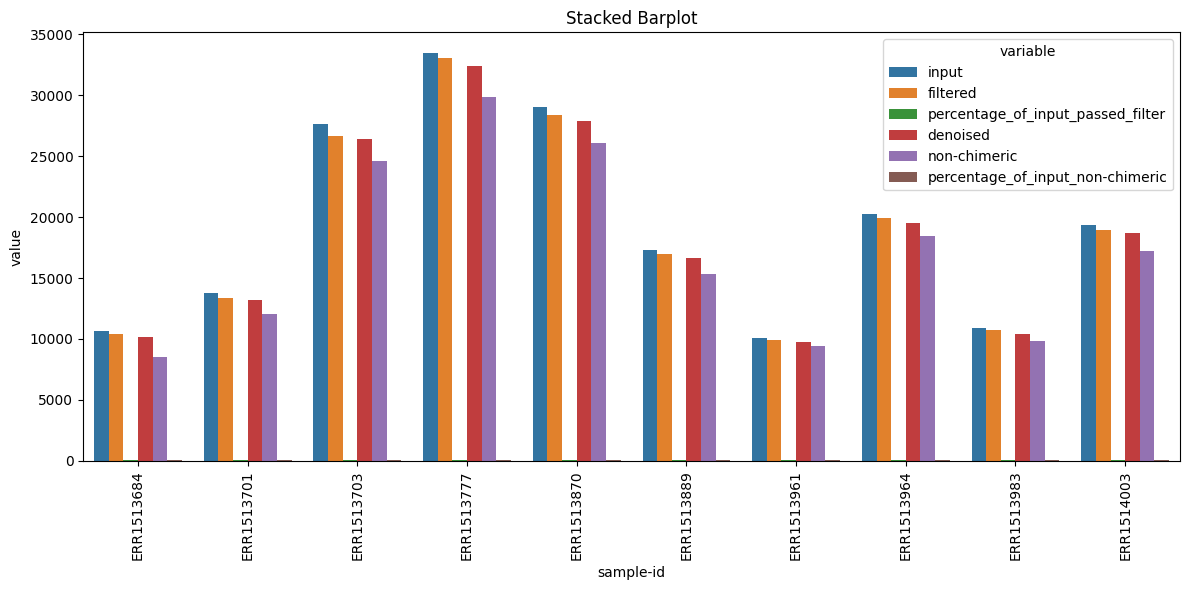

✅ Successfully generated denoising_stats.qzv
✅ tree folder sudah ada
✅ diversity folder sudah ada

🔍 Classifying with Silva Database...
✅ Using existing pre-trained classifier
🔄 Running classification with memory optimization...
🚀 Running: Memory-optimized SILVA classification
✅ Directory silva_phylogenetic already exists
🚀 Running: Taxonomic barplot
🚀 Running: Collapse to level 6
✅ Directory exported_silva already exists
✅ Diversity analysis already completed - skipping computation

📊 Top Taxa:
                                                Taxon  ERR1513684  ERR1513701  \
0   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...      2446.0      3456.0   
1   d__Bacteria;p__Proteobacteria;c__Gammaproteoba...      1583.0        59.0   
2   d__Bacteria;p__Proteobacteria;c__Gammaproteoba...      1267.0       565.0   
3   d__Bacteria;p__Proteobacteria;c__Gammaproteoba...         0.0         0.0   
4   d__Bacteria;p__Firmicutes;c__Clostridia;o__Osc...       814.0         0.0   
5   d__Bacter

/tmp/ipykernel_35/3584965458.py:1347: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

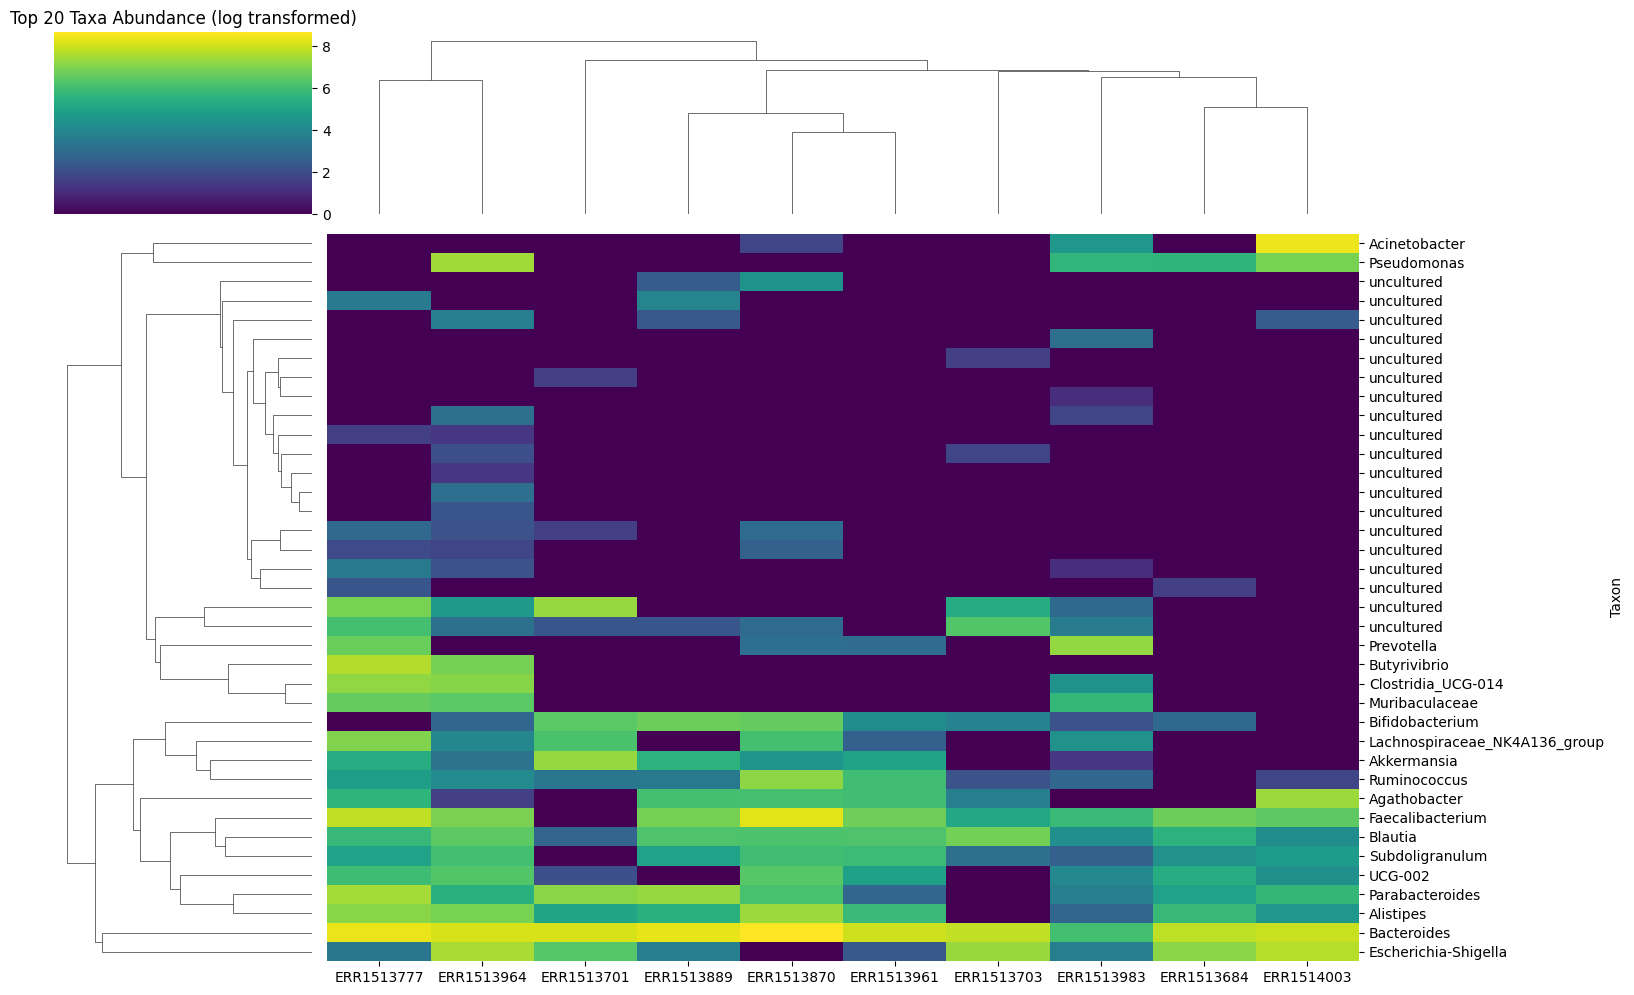

In [45]:
# Opsi 1: QIIME2 pretrained classifier
results = classifier.run_classification(
    #input_fastq="/content/materials/data/ERR1513684.fastq.gz",
    method="silva",
    #classifier_path="/content/tirta_real_data/taxonomy_db/silva-138-99-tax-515-806.qza",
    # metadata_path="/kaggle/working/tirta_real_data/sra_downloads/qiime2_metadata_new.tsv",
    # manifest_path="/kaggle/working/tirta_real_data/sra_downloads/qiime2_manifest.tsv",
    metadata_path="/kaggle/working/materials/data/metadata.tsv",
    manifest_path="/kaggle/working/materials/data/manifest_update.tsv",
    n_jobs = 4,
    tax_level = 6,
    top_n = 20,
    biobert_batch_size=64,  # Optional: sesuaikan dengan GPU Anda
    plot_diversity=True,
    diversity_group_column= "parkinson_disease", #"parkinson_disease",#"cure_status",
    use_pretrained = True
)

# **TEST DATA REAL**

In [50]:
# Inisialisasi
classifier = BioTaxClassifier(
    folder_name = "tirta_ncbi_data",
    email="your_email@example.com",
    #base_path= "/content", # Sesuaikan dengan environment Anda
    qiime_version="2023.9", #"2025.4" -> NEW, #"2023.9" -> STABLE
    beta_div = "cure_status" #"parkinson_disease" #"cure_status"
)

✅ Main project folder created at: /kaggle/working/tirta_ncbi_data
  ├── Created subfolder: qiime_output
  ├── Created subfolder: sra_downloads
  ├── Created subfolder: visualizations
  ├── Created subfolder: taxonomy
  ├── Created subfolder: exported
  ├── Created subfolder: models
  ├── Created subfolder: taxonomy_db
  ├── Created subfolder: biobert_resources
✅ QIIME2 sudah terinstall


In [51]:
downloader = SRAExplorerDownloader(email="your_email@example.com",
                                   output_dir="/kaggle/working/tirta_ncbi_data/sra_downloads",
                                   retmax=50)
downloader.run_pipeline(sra_ids=[
        "SRR26471833",
        "SRR26471832",
        "SRR26471831",
        "SRR26471838",
        "SRR26471836",
        "SRR26471835",
        ])

def add_metadata_columns(metadata_df):
    """
    Menambahkan kolom 'smoking_status' dan 'Disease_State' ke DataFrame berdasarkan mapping sample-id.

    Args:
        metadata_df (pd.DataFrame): DataFrame asal dengan kolom 'sample-id'.

    Returns:
        pd.DataFrame: DataFrame dengan kolom tambahan.
    """
    # Mapping sample-id ke smoking_status dan Disease_State
    mapping = {
        "SRR26471833": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2017", "age":"54", "sex":"female", "cure_status":"0 month"},
        "SRR26471832": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2017", "age":"54", "sex":"female", "cure_status":"3 month"},
        "SRR26471831": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2018", "age":"54", "sex":"female", "cure_status":"6 month"},
        "SRR26471838": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2018", "age":"58", "sex":"female", "cure_status":"0 month"},
        "SRR26471836": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2018", "age":"58", "sex":"female", "cure_status":"3 month"},
        "SRR26471835": {"isolation_loc": "stool", "host_disease": "COPD", "geo_loc": "omaha", "year" : "2018", "age":"58", "sex":"female", "cure_status":"6 month"},
    }

    # Tambahkan kolom baru berdasarkan mapping
    metadata_df["isolation_loc"] = metadata_df["sample-id"].map(lambda x: mapping[x]["isolation_loc"])
    metadata_df["host_disease"] = metadata_df["sample-id"].map(lambda x: mapping[x]["host_disease"])
    metadata_df["geo_loc"] = metadata_df["sample-id"].map(lambda x: mapping[x]["geo_loc"])
    metadata_df["year"] = metadata_df["sample-id"].map(lambda x: mapping[x]["year"])
    metadata_df["age"] = metadata_df["sample-id"].map(lambda x: mapping[x]["age"])
    metadata_df["sex"] = metadata_df["sample-id"].map(lambda x: mapping[x]["sex"])
    metadata_df["cure_status"] = metadata_df["sample-id"].map(lambda x: mapping[x]["cure_status"])
    #metadata_df["drug_usage"] = metadata_df["sample-id"].map(lambda x: mapping[x]["drug_usage"])

    return metadata_df

# Contoh penggunaan
metadata = pd.read_csv('/kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_metadata.tsv', sep='\t')
metadata_used = add_metadata_columns(metadata)
metadata_used.to_csv('/kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_metadata_new.tsv', sep='\t', index=False)
metadata_used

[INFO] Using provided SRA IDs: SRR26471833, SRR26471832, SRR26471831...
[INFO] Fetching XML metadata for SRR26471833...
[INFO] Fetching XML metadata for SRR26471832...
[INFO] Fetching XML metadata for SRR26471831...
[INFO] Fetching XML metadata for SRR26471838...
[INFO] Fetching XML metadata for SRR26471836...
[INFO] Fetching XML metadata for SRR26471835...

[RESULTS] Found 6 datasets:

1. Diet-Microbiome Interactions Influence Lung Function in Chronic Obstructive Pulmonary Disease
   Organism: gut metagenome | Technology: Illumina MiSeq | Date: Unknown
   Run IDs: SRR26471833

2. Diet-Microbiome Interactions Influence Lung Function in Chronic Obstructive Pulmonary Disease
   Organism: gut metagenome | Technology: Illumina MiSeq | Date: Unknown
   Run IDs: SRR26471832

3. Diet-Microbiome Interactions Influence Lung Function in Chronic Obstructive Pulmonary Disease
   Organism: gut metagenome | Technology: Illumina MiSeq | Date: Unknown
   Run IDs: SRR26471831

4. Diet-Microbiome Intera

spots read      : 180,341
reads read      : 360,682
reads written   : 360,682


[DONE] SRR26471833 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[DOWNLOAD] Starting download for: SRR26471832
[INFO] Free disk space: 9.90 GB
2025-05-22T05:35:58 prefetch.3.2.1: 1) Resolving 'SRR26471832'...
2025-05-22T05:36:00 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-05-22T05:36:00 prefetch.3.2.1: 1) Downloading 'SRR26471832'...
2025-05-22T05:36:00 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-05-22T05:36:00 prefetch.3.2.1:  Downloading via HTTPS...
2025-05-22T05:36:02 prefetch.3.2.1:  HTTPS download succeed
2025-05-22T05:36:02 prefetch.3.2.1:  'SRR26471832' is valid: 62449692 bytes were streamed from 62441447
2025-05-22T05:36:02 prefetch.3.2.1: 1) 'SRR26471832' was downloaded successfully
2025-05-22T05:36:02 prefetch.3.2.1: 1) Resolving 'SRR26471832's dependencies...
2025-05-22T05:36:02 prefetch.3.2.1: 'SRR26471832' has 0 unresolved dependencies
[INFO] Conver

spots read      : 191,618
reads read      : 383,236
reads written   : 383,236


[DONE] SRR26471832 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[DOWNLOAD] Starting download for: SRR26471831
[INFO] Free disk space: 9.58 GB
2025-05-22T05:36:05 prefetch.3.2.1: 1) Resolving 'SRR26471831'...
2025-05-22T05:36:07 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-05-22T05:36:07 prefetch.3.2.1: 1) Downloading 'SRR26471831'...
2025-05-22T05:36:07 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-05-22T05:36:07 prefetch.3.2.1:  Downloading via HTTPS...
2025-05-22T05:36:10 prefetch.3.2.1:  HTTPS download succeed
2025-05-22T05:36:10 prefetch.3.2.1:  'SRR26471831' is valid: 73631653 bytes were streamed from 73628435
2025-05-22T05:36:10 prefetch.3.2.1: 1) 'SRR26471831' was downloaded successfully
2025-05-22T05:36:10 prefetch.3.2.1: 1) Resolving 'SRR26471831's dependencies...
2025-05-22T05:36:10 prefetch.3.2.1: 'SRR26471831' has 0 unresolved dependencies
[INFO] Conver

spots read      : 222,421
reads read      : 444,842
reads written   : 444,842


[DONE] SRR26471831 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[DOWNLOAD] Starting download for: SRR26471838
[INFO] Free disk space: 9.20 GB
2025-05-22T05:36:14 prefetch.3.2.1: 1) Resolving 'SRR26471838'...
2025-05-22T05:36:15 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-05-22T05:36:15 prefetch.3.2.1: 1) Downloading 'SRR26471838'...
2025-05-22T05:36:15 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-05-22T05:36:15 prefetch.3.2.1:  Downloading via HTTPS...
2025-05-22T05:36:17 prefetch.3.2.1:  HTTPS download succeed
2025-05-22T05:36:18 prefetch.3.2.1:  'SRR26471838' is valid: 81724665 bytes were streamed from 81719466
2025-05-22T05:36:18 prefetch.3.2.1: 1) 'SRR26471838' was downloaded successfully
2025-05-22T05:36:18 prefetch.3.2.1: 1) Resolving 'SRR26471838's dependencies...
2025-05-22T05:36:18 prefetch.3.2.1: 'SRR26471838' has 0 unresolved dependencies
[INFO] Conver

spots read      : 248,124
reads read      : 496,248
reads written   : 496,248


[DONE] SRR26471838 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[DOWNLOAD] Starting download for: SRR26471836
[INFO] Free disk space: 8.77 GB
2025-05-22T05:36:21 prefetch.3.2.1: 1) Resolving 'SRR26471836'...
2025-05-22T05:36:22 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-05-22T05:36:22 prefetch.3.2.1: 1) Downloading 'SRR26471836'...
2025-05-22T05:36:22 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-05-22T05:36:22 prefetch.3.2.1:  Downloading via HTTPS...
2025-05-22T05:36:24 prefetch.3.2.1:  HTTPS download succeed
2025-05-22T05:36:25 prefetch.3.2.1:  'SRR26471836' is valid: 74886065 bytes were streamed from 74879455
2025-05-22T05:36:25 prefetch.3.2.1: 1) 'SRR26471836' was downloaded successfully
2025-05-22T05:36:25 prefetch.3.2.1: 1) Resolving 'SRR26471836's dependencies...
2025-05-22T05:36:25 prefetch.3.2.1: 'SRR26471836' has 0 unresolved dependencies
[INFO] Conver

spots read      : 226,651
reads read      : 453,302
reads written   : 453,302


[DONE] SRR26471836 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[DOWNLOAD] Starting download for: SRR26471835
[INFO] Free disk space: 8.39 GB
2025-05-22T05:36:28 prefetch.3.2.1: 1) Resolving 'SRR26471835'...
2025-05-22T05:36:29 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-05-22T05:36:29 prefetch.3.2.1: 1) Downloading 'SRR26471835'...
2025-05-22T05:36:29 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-05-22T05:36:29 prefetch.3.2.1:  Downloading via HTTPS...
2025-05-22T05:36:32 prefetch.3.2.1:  HTTPS download succeed
2025-05-22T05:36:32 prefetch.3.2.1:  'SRR26471835' is valid: 81503404 bytes were streamed from 81494466
2025-05-22T05:36:32 prefetch.3.2.1: 1) 'SRR26471835' was downloaded successfully
2025-05-22T05:36:32 prefetch.3.2.1: 1) Resolving 'SRR26471835's dependencies...
2025-05-22T05:36:32 prefetch.3.2.1: 'SRR26471835' has 0 unresolved dependencies
[INFO] Conver

spots read      : 243,676
reads read      : 487,352
reads written   : 487,352


[DONE] SRR26471835 successfully downloaded to /kaggle/working/tirta_ncbi_data/sra_downloads

[QIIME2] Generating manifest file...
[MERGING] Combining paired-end files for SRR26471833
[MERGING] Combining paired-end files for SRR26471832
[MERGING] Combining paired-end files for SRR26471831
[MERGING] Combining paired-end files for SRR26471838
[MERGING] Combining paired-end files for SRR26471836
[MERGING] Combining paired-end files for SRR26471835
[DONE] Manifest saved: /kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_manifest.tsv

[QIIME2] Generating metadata.tsv file...
[SUCCESS] Clean QIIME2 metadata saved: /kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_metadata.tsv


,sample-id,organism,technology,title,isolation_loc,host_disease,geo_loc,year,age,sex,cure_status
0,SRR26471833,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2017,54,female,0 month
1,SRR26471832,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2017,54,female,3 month
2,SRR26471831,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2018,54,female,6 month
3,SRR26471838,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2018,58,female,0 month
4,SRR26471836,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2018,58,female,3 month
5,SRR26471835,gut metagenome,Illumina MiSeq,Diet-Microbiome Interactions Influence Lung Fu...,stool,COPD,omaha,2018,58,female,6 month


In [49]:
!rm -rf /kaggle/working/tirta_real_data/sra_downloads/*

In [ ]:
import sys
import time
import contextlib
with open('install.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !pip install empress
        !conda install -c bioconda sra-tools -y
        end = time.time()
        # -- End installation --
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

In [ ]:
results = classifier.run_classification(
    #input_fastq="/content/materials/data/ERR1513684.fastq.gz",
    method="silva",
    metadata_path="/kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_metadata_new.tsv",
    manifest_path="/kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_manifest.tsv",
    n_jobs = 4,
    tax_level = 6,
    top_n = 20,
    biobert_batch_size=64,  # Optional: sesuaikan dengan GPU Anda
    plot_diversity=True,
    diversity_group_column= "cure_status", #"parkinson_disease",#"cure_status",
    use_pretrained = True
)

✅ Using existing metadata file: /kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_metadata_new.tsv
✅ Using existing manifest file: /kaggle/working/tirta_ncbi_data/sra_downloads/qiime2_manifest.tsv
⏳ Importing sequences into QIIME2 format...
🚀 Running: Importing sequences
✅ Successfully imported sequences and generate artefak sequences.qza
🚀 Running: Check sequence qualyties
✅ Successfully generated qualities.qzv
🚀 Running: Denoising & Filtering with DADA2
